# Set up

In [ ]:
!python -V

Python 3.11.11


In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


Mount the Google drive.

Mount your Google drive to store the dataset and the trained models. Execute the cell below. Visit this [URL](https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code) to retrieve the authorization code and enter the code at the prompt.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Directory Navigation

In [ ]:
from os import path, chdir, getcwd, mkdir

# Choose a project name
projectName = "Glass-ANN/"

# Project directory is in My Drive
projectDirectory = "/content/drive/My Drive/" + projectName #content/drive/My Drive/glassCNN/
# Checks if cwd is in content folder
if getcwd() == "/content":
  # Makes project directory if it does not exist
  if not path.isdir(projectDirectory):
    mkdir(projectDirectory)
    print(f"Project {projectName} has been created!")
  else:
    print(f"Project {projectName} already exist!")
  # Changes to project directory
  chdir(projectDirectory)

print(f"The current working directory is {getcwd()}")

Project Glass-ANN/ already exist!
The current working directory is /content/drive/My Drive/Glass-ANN


Install dependencies

In [ ]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

Check GPU

In [ ]:
# Check if runtime uses GPU
import torch

gpu_name = torch.cuda.get_device_name(0)
print("Using GPU", gpu_name)

Using GPU Tesla T4


# Dataset

## Dataset with variable number of labels
tempered glass dataset:

folder:
input x (images):
    - /all_photos/paper or /all_photos/plastic
    - R/P 01.png

input y (labels):
    - dataset.csv
    - 3 parameters,

    0: angle
    1: velocity
    2: kinetic energy







In [ ]:
import os
import csv

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd

class LabeledGlassSet(Dataset):
    """Parameters:
            - train_test_defined (bool): Whether to use predefined train/test split.
            - is_train (bool): If True, loads training images; otherwise, testing images.
            - combine_images (bool): Whether to concatenate corresponding P# and R# images into a single tensor.
            - image_type (str): Specifies which images to load when not combining. Options: 'plastic', 'paper', 'both'.
            - labels_set (list of int): Indices of the labels to extract from the labels file.
            """

    def __init__(self, train_test_defined=False, is_train=False, combine_images=True, image_type='both', labels_set=[0,1]):
        self.train_test_defined = train_test_defined
        self.is_train = is_train
        self.combine_images_into_one = combine_images
        self.image_type = image_type
        self.labels_set = labels_set

        # Paths for train/test or all_photos
        if train_test_defined:
            path_tail = 'train_photos' if is_train else 'test_photos'
            self.data_path = os.path.join(projectDirectory, path_tail)
        else:

            #for extended plastic pictures
            self.data_path = os.path.join(projectDirectory, 'Plastic(extended)')
            #self.data_path = os.path.join(projectDirectory, 'Plastic (full 4 by 3) augmented')


            #self.data_path = os.path.join(projectDirectory, 'Plastic_cropped(extended)')
            #self.data_path = os.path.join(projectDirectory, 'plastic_cropped (full) augmented')


        # Path for labels CSV
        #self.labels_path = os.path.join(projectDirectory, 'labels_regularised.csv')
        self.labels_path = os.path.join(projectDirectory, 'labels_regularised_plastic_new.csv')

        #only for augmentation!!
        #self.labels_path = os.path.join(projectDirectory, 'labels_regularised_angle_augmented_final.csv')

        # Load filenames and labels
        self.image_files = self._load_file_list()
        self.labels_dict = self._load_labels()

    def __len__(self):
        return len(self.image_files)

    # load and filter image filenames
    # output: sorted list of image filenames
    def _load_file_list(self):
        image_files = []

        if self.combine_images_into_one:
          # Get all image names (without `.jpg`) in the folder
          image_names = {f[:-4] for f in os.listdir(self.data_path) if f.endswith('.jpg')}
          print("\n[DEBUG] All image names found (without extensions):", image_names)

          # Filter only `P#` images that have a corresponding `R#` image (ensuring uniqueness)
          paired_images = sorted(set(f"P{num[1:]}" for num in image_names if f"R{num[1:]}" in image_names))

          print("\n[DEBUG] Filtered paired image names (P# that has R# pair):", paired_images)
          print("\n[DEBUG] Total paired images (should be 35 if correct):", len(paired_images))

          return paired_images  # Returns only unique `P#` images


        for filename in os.listdir(self.data_path):
            if filename.endswith('.jpg'):
                if self.image_type == 'plastic' and filename.startswith('P'):
                    image_files.append(filename)
                elif self.image_type == 'paper' and filename.startswith('R'):
                    image_files.append(filename)
                elif self.image_type == 'both':
                    image_files.append(filename)

        return sorted(image_files)

    # load labels from excel and map them to image filenames
    #output: dict: keys = image names, values = label lists
    def _load_labels(self):
        labels_dict = {}
        labels_df = pd.read_csv(self.labels_path)  # Read the Excel file

        # Generate filenames based on the row index
        for idx, row in labels_df.iterrows():
            plastic_name = f"P{idx+1:02d}"  # P01, P02, etc.
            paper_name = f"R{idx+1:02d}"    # R01, R02, etc.

            # Map each filename to the corresponding labels
            labels_dict[plastic_name] = row.tolist()
            labels_dict[paper_name] = row.tolist()

        return labels_dict
    #inherited function from Dataset class
    #retrieve data sample at given index
    #output: dict containing:
    # img (Tensor): processed image tensor
    # label (Tensor): corresponding label tensor
    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        base_name = os.path.splitext(image_name)[0]  # Get filename without extension

        # Get label based on selected label indices
        try:
          label = torch.tensor([self.labels_dict[base_name][i] for i in self.labels_set])
        except:
          print("⚠️ Warning: Label not found for:", base_name)
          print("Labels available:", self.labels_dict.get(base_name, "No entry"))
          print("Labels set requested:", self.labels_set)
          return {'img': torch.zeros(6, 336, 336), 'label': torch.zeros(len(self.labels_set))}


        # Load image(s)
        if self.combine_images_into_one:
            plastic_path = os.path.join(self.data_path, f'P{base_name[1:]}.jpg')  # Ensure correct extension
            paper_path = os.path.join(self.data_path, f'R{base_name[1:]}.jpg')
            img_plastic = self._load_image(plastic_path)
            img_paper = self._load_image(paper_path)
            img = torch.cat((img_plastic, img_paper), dim=0)
        else:
            img_path = os.path.join(self.data_path, image_name)
            img = self._load_image(img_path)

        return {'img': img, 'label': label}

    #loads and preprocesses an imaage
    #output: preprocessed image tensor
    def _load_image(self, image_path):
        img = Image.open(image_path).convert('RGB')

        #debug: print original image dimensions
        #should be 4000 by 3000
        #print(f"[DEBUG] Original size of {os.path.basename(image_path)}: {img.size}")  # (width, height)

        #img = img.resize((336, 504))  # Resize for the model into aspect 3:2 (CROPPED)
        #img = img.resize((672, 1008))  # Resize for the model into aspect 3:2 (CROPPED 2x)
        #img = img.resize((168, 252))  # Resize for the model into aspect 3:2 (CROPPED 0.5x)
        #img = img.resize((84, 126))  # Resize for the model into aspect 3:2 (CROPPED 0.5x)

        img = img.resize((336, 448))  # Resize for the model into aspect 4:3 (NORMAL)
        #img = img.resize((672, 896))  # Resize for the model into aspect 4:3 (NORMAL 2x)
        #img = img.resize((168, 224))  # Resize for the model into aspect 4:3 (NORMAL 0.5x)

        #WRONG DIMENSIONS
        #img = img.resize((504, 336))  # Resize for the model into aspect 3:2
        #img = img.resize((1008, 672))  # Resize for the model into aspect 3:2
        #img = img.resize((448, 336))  # Resize for the model into aspect 4:3
        #img = img.resize((896, 672))  # Resize for the model into aspect 4:3
        #img = img.resize((336, 336))  # Resize for the model


        # Normalize the image and convert to Tensor
        normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        img_transforms = transforms.Compose([transforms.ToTensor(), normalize])

        #additional image processing can be added here if required

        ###########################################################
        return img_transforms(img)



# ANN models

## Loss functions

In [ ]:
import torch
import torch.nn as nn

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(pred, actual))


## AlexNet

In [ ]:
import torch
import torch.nn as nn

from typing import Union, List, Dict, Any, cast

class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 6, input_dim: int = 3) -> None:
        print('input dimensions ', input_dim)
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            #number of  channels, number of filters, each of size__, stride, padding)
            nn.Conv2d(input_dim, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> AlexNet:
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    The required minimum input size of the model is 63x63.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


## VGG

In [ ]:
import torch
import torch.nn as nn

from typing import Union, List, Dict, Any, cast

class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 6,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) #adapts spacial dimensions of feature map to 7 x 7
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None: #initialize weight of the conv and FCC layers at the start
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False, input_dim: int = 3) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = input_dim
    print('input dimensions: ', input_dim)
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'F': [128, 128, 'M', 256, 256, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, input_dim: int = 3, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm, input_dim=input_dim), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, input_dim, **kwargs)


def vgg11_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, input_dim, **kwargs)


def vgg13(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, input_dim, **kwargs)


def vgg13_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, input_dim, **kwargs)


def vgg16(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, input_dim, **kwargs)


def vgg16_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)


def vgg19(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', False, pretrained, progress, input_dim, **kwargs)


def vgg19_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, input_dim, **kwargs)

def vgg19f(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'F', False, pretrained, progress, input_dim, **kwargs)


## Small(-er) VGG

In [ ]:
import torch
import torch.nn as nn

from typing import Union, List, Dict, Any, cast

class VGGsmall(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 6,
        init_weights: bool = True
      ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False, input_dim: int = 3) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = input_dim
    print('input dimensions: ', input_dim)
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'F': [128, 128, 'M', 256, 256, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, input_dim: int = 3, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGGsmall(make_layers(cfgs[cfg], batch_norm=batch_norm, input_dim=input_dim), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, input_dim, **kwargs)


def vgg11_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, input_dim, **kwargs)


def vgg13(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, input_dim, **kwargs)


def vgg13_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, input_dim, **kwargs)


def vgg16(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, input_dim, **kwargs)


def vgg16_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)


def vgg19(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', False, pretrained, progress, input_dim, **kwargs)


def vgg19_bn(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, input_dim, **kwargs)

def vgg19f(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'F', False, pretrained, progress, input_dim, **kwargs)


## ResNet

In [ ]:
!pip install pytorchcv
!pip install pytorchcv torch>=0.4.0

import torch
from torch import Tensor
import torch.nn as nn

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


# from .._internally_replaced_utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        input_dim: int = 9
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(input_dim, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        ## FOR UNCERTAINTY-BASED MODELLING
        #self.log_sigma1 = nn.Parameter(torch.tensor(0.2))  # For angle
        #self.log_sigma2 = nn.Parameter(torch.tensor(-0.5))  # For velocity


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    ## FOR UNCERTAINTY-BASED MODELLING
    #def get_task_uncertainty(self):
        #return self.log_sigma1, self.log_sigma2



def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    input_dim: int = 3,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, input_dim=input_dim, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bol): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, input_dim, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, input_dim: int = 3, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, input_dim, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

from pytorchcv.model_provider import get_model as ptcv_get_model
net = ptcv_get_model("resnet18", pretrained=True)

from torch.autograd import Variable
x = Variable(torch.randn(1, 3, 224, 224))

y = net(x)

y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 16.3 MB/s eta 0:00:00


tensor([[-2.0020e-01, -1.0241e-01,  2.1624e-01,  9.8917e-02,  1.7338e-01,
          1.1200e-03,  9.0369e-02, -4.5892e-02,  1.1195e-01, -4.2831e-02,
         -4.4581e-02, -1.8843e-01,  2.3441e-02,  5.5275e-02, -1.4751e-01,
         -7.9373e-02, -3.1740e-01, -6.9560e-02,  6.3612e-02, -9.2441e-02,
         -1.0607e-01, -1.1986e-01, -1.9528e-01,  6.1830e-02, -7.8652e-02,
         -1.4140e-01,  6.2375e-02,  3.9536e-02, -3.0446e-02, -2.3808e-01,
          2.0328e-01, -1.3650e-02, -7.0095e-02, -2.3826e-01, -1.3333e-01,
         -2.2821e-02,  1.0134e-02, -1.9875e-01,  6.9238e-02, -1.8215e-01,
          2.1188e-02, -1.2839e-01, -1.7823e-01, -1.2269e-01,  2.4429e-02,
         -1.0687e-01,  1.6889e-01, -3.0198e-01, -3.5566e-01, -2.3338e-01,
          1.0402e-01, -1.3936e-01,  8.4607e-02, -6.0163e-03,  1.2681e-01,
         -5.9807e-02, -4.9070e-02,  5.1303e-02,  1.8882e-01,  1.1971e-02,
          2.9665e-01, -1.0727e-01, -2.0148e-01, -1.2364e-01, -7.0934e-02,
          4.7564e-02,  6.9866e-02,  5.

# Train and Test functions

### CNN-specific parameters:


#### optimizer: Defines how the model updates its weights during training.
        Options include:
            - Adam (used here): Adaptive learning rate optimization, generally fast and efficient.
            - SGD (Stochastic Gradient Descent): Slower but sometimes more robust for large datasets.


### loss_func: Specifies the function used to compute the difference between predictions and ground truth.
        * MSELoss: Mean Squared Error, suitable for regression tasks.
        * L1Loss: Mean Absolute Error, used here for validation.
        * Custom losses (e.g., RMSE) can be substituted based on task requirements.


### scheduler: Dynamically adjusts the learning rate during training.
        * ReduceLROnPlateau: Lowers the learning rate if the validation loss plateaus, helping to fine-tune the model during later epochs.


### num_epoch: Total number of epochs for training.
        * Each epoch represents one complete pass through the training dataset.

### batch_size: Number of samples processed together in a single forward/backward pass.
        * Affects memory usage and training stability.

### look at kfold spliting indexes

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Simulating your dataset with 57 samples (just numbers 0 to 56)
num_samples = 57
dataset_indices = np.arange(num_samples)

# Define KFold parameters
k = 3  # Number of folds
kfold = KFold(n_splits=k, shuffle=True, random_state=42)  # Ensure deterministic splits

# Print the split indices
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset_indices)):
    print(f"Fold {fold + 1}:")
    print(f"Train Indices: {train_idx}")
    print(f"Validation Indices: {val_idx}\n")



Fold 1:
Train Indices: [ 1  2  7  9 10 11 14 15 16 18 19 20 21 22 23 24 25 28 29 32 33 35 36 37
 38 39 41 42 44 46 48 49 50 51 52 53 54 56]
Validation Indices: [ 0  3  4  5  6  8 12 13 17 26 27 30 31 34 40 43 45 47 55]

Fold 2:
Train Indices: [ 0  1  2  3  4  5  6  7  8 10 12 13 14 17 18 20 21 22 23 26 27 28 30 31
 34 35 38 39 40 42 43 44 45 46 47 51 55 56]
Validation Indices: [ 9 11 15 16 19 24 25 29 32 33 36 37 41 48 49 50 52 53 54]

Fold 3:
Train Indices: [ 0  3  4  5  6  8  9 11 12 13 15 16 17 19 24 25 26 27 29 30 31 32 33 34
 36 37 40 41 43 45 47 48 49 50 52 53 54 55]
Validation Indices: [ 1  2  7 10 14 18 20 21 22 23 28 35 38 39 42 44 46 51 56]



### Train and Test with MSE printed

In [ ]:
from sklearn.model_selection import KFold
import torch
import os
import pandas as pd

def labeled_kfold_train_with_mse(model_str, num_epoch=100, batch_size=4, labels_set=[], k=4, verbose=True, save_dir=None, combine_images=False, image_type='both'):
    #Perform k-fold cross-validation for training a PyTorch model with MSE and MAE for validation.
    uncertain = False

    # Initialize dataset
    print(f"Initializing dataset with combin_images as {combine_images}")
    dataset = LabeledGlassSet(
        train_test_defined=False,
        is_train=False,
        combine_images=combine_images,
        image_type=image_type,
        labels_set=labels_set
    )

    print(f"Total dataset items: {len(dataset)}")
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    if save_dir is not None and k > 2:
        base_save_dir = save_dir.split('.')[0]  # remove .pt
        os.makedirs(base_save_dir, exist_ok=True)
    else:
        base_save_dir = None

    print("Starting k-fold cross-validation...")

    # Prepare dictionary to store loss values
    results_stats = {"Epoch": list(range(1, num_epoch + 1))}
    for f in range(k):
        results_stats[f"Fold {f + 1} - Train Loss"] = [None] * num_epoch
        results_stats[f"Fold {f + 1} - Val Loss (MAE)"] = [None] * num_epoch
        results_stats[f"Fold {f + 1} - Val Loss (MSE)"] = [None] * num_epoch

    all_folds = list(enumerate(kfold.split(dataset)))

    fold_count = 0

    for fold, (train_idx, val_idx) in all_folds:

        print(f"\nFold {fold + 1}/{k}")

        # Split dataset into training and validation subsets
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        # Create data loaders
        train_loader = torch.utils.data.DataLoader(
            train_subset, batch_size=batch_size, shuffle=True, pin_memory=True
        )
        val_loader = torch.utils.data.DataLoader(
            val_subset, batch_size=batch_size, shuffle=False, pin_memory=True
        )

        # Initialize model, optimizer, and scheduler
        learning_rate = 1e-5
        factor = 0.5
        patience = 5
        threshold = 1e-4
        min_lr = 1e-6
        print(f"Learning rate: {learning_rate}")
        print(f"Factor: {factor}, Patience: {patience}, Threshold: {threshold}, Min LR: {min_lr}")

        model = get_model(model_str)
        my_model = model.cuda().float()


        #CURRENT OPTIMISATION FUNCTION: ADAM
        optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)


        # CURRENT LOSS_FUNCTION
        loss_func = torch.nn.MSELoss()  # Training loss (MSE)

        val_loss_func = torch.nn.L1Loss()   # Validation loss (MAE)
        val_loss_func_mse = torch.nn.MSELoss()  # Validation loss (MSE)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 'min', factor=factor, patience=patience, threshold=threshold, verbose=True, min_lr=min_lr
        )



        min_val_loss = float('inf')

        for epoch in range(num_epoch):
            # ===========================
            #  Training Phase
            # ===========================
            my_model.train()
            total_train_loss = 0
            for data in train_loader:
                optimizer.zero_grad()
                labels = data['label'].cuda().float()
                img = data['img'].cuda().float()

                # Prediction
                prediction = my_model(img)
                #prediction = my_model(img).clamp(0, 1)  # Clamping predictions

                # Compute MSE Loss
                # CAN MODIFY TO INCLUDE UNCERTAINTY
                if not uncertain:
                  loss = loss_func(prediction, labels.reshape(prediction.shape))

                else:
                  #uncertainty
                  """angle_pred = prediction[:, 0]
                  vel_pred = prediction[:, 1]
                  angle_true = labels[:, 0]
                  vel_true = labels[:, 1]

                  angle_loss = torch.nn.functional.mse_loss(angle_pred, angle_true)
                  vel_loss = torch.nn.functional.mse_loss(vel_pred, vel_true)

                  sigma1 = torch.exp(my_model.log_sigma1)
                  sigma2 = torch.exp(my_model.log_sigma2)
                  constant = 100

                  loss = (1*constant / (2 * sigma1**2)) * angle_loss + torch.log(sigma1) + \
                        (1*constant / (2 * sigma2**2)) * vel_loss + torch.log(sigma2)"""
                  #######################################################################
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)

            # ===========================
            #  Validation Phase
            # ===========================
            my_model.eval()
            total_val_loss = 0
            total_val_loss_mse = 0

            with torch.no_grad():
                for data in val_loader:
                    labels = data['label'].cuda().float()
                    img = data['img'].cuda().float()

                    prediction = my_model(img).clamp(0, 1)  # Clamp predictions to [0, 1]

                    # Compute MAE and MSE for validation
                    val_loss = val_loss_func(prediction, labels.reshape(prediction.shape))
                    val_loss_mse = val_loss_func_mse(prediction, labels.reshape(prediction.shape))

                    total_val_loss += val_loss.item()
                    total_val_loss_mse += val_loss_mse.item()

                    # Sanity Checks
                    if epoch % 10 == 0 and len(val_loader) < 5:
                        print(f"Val Sample Check - Epoch {epoch + 1}")
                        print(f"Predictions range: {prediction.min().item()} to {prediction.max().item()}")
                        print(f"Labels range: {labels.min().item()} to {labels.max().item()}")

            avg_val_loss = total_val_loss / len(val_loader)  # Average MAE
            avg_val_loss_mse = total_val_loss_mse / len(val_loader)  # Average MSE

            # ===========================
            #  Logging and Reporting
            # ===========================
            scheduler.step(avg_val_loss)

            results_stats[f"Fold {fold + 1} - Train Loss"][epoch] = avg_train_loss
            results_stats[f"Fold {fold + 1} - Val Loss (MAE)"][epoch] = avg_val_loss
            results_stats[f"Fold {fold + 1} - Val Loss (MSE)"][epoch] = avg_val_loss_mse

            if verbose:
                if not uncertain:
                    print(f"Epoch {epoch + 1}/{num_epoch}: "
                          f"Train Loss: {avg_train_loss:.4f}, "
                          f"Val Loss (MAE): {avg_val_loss:.4f}, "
                          f"Val Loss (MSE): {avg_val_loss_mse:.4f}")

                else:
                    print(f"Epoch {epoch + 1}/{num_epoch}: "
                    f"Total Loss (MSE): {avg_train_loss:.4f}, "
                    f"Angle Loss (MSE): {angle_loss.item():.4f}, "
                    f"Velocity Loss (MSE): {vel_loss.item():.4f}, "
                    f"σ1: {sigma1.item():.4f}, σ2: {sigma2.item():.4f}")

            # ===========================
            # Save Best Model
            # ===========================
            if avg_val_loss < min_val_loss:
                min_val_loss = avg_val_loss
                if save_dir is not None:
                    if k > 2:
                        fold_save_path = os.path.join(base_save_dir, f'fold_{fold + 1}_best_model.pt')
                    else:
                        fold_save_path = save_dir
                    torch.save(my_model.state_dict(), fold_save_path)
                    print(f" Model updated in epoch {epoch + 1}, saved to {fold_save_path}")

        print(f"Fold {fold + 1} Final Validation Loss (MAE): {min_val_loss:.4f}")
        ###########################################################################

        ############################################################################
        fold_results.append(min_val_loss)

    # ===========================
    # Save Final Results to CSV
    # ===========================
    df_results = pd.DataFrame(results_stats)
    df_results.to_csv(os.path.join(base_save_dir, 'results_with_mse.csv'), index=False)
    avg_loss = sum(fold_results) / len(fold_results)
    print(f"\n🔥 Average Validation Loss Across Folds (MAE): {avg_loss:.4f}")
    return avg_loss


def labeled_test(model, batch_size=1, labels_set=[], combine_images=True, image_type='both', save_path="test_results.xlsx",  want_normalise=False):
    """
    Tests the model using the LabeledGlassSet dataset.

    Parameters:
    - model: The PyTorch model to be tested.
    - batch_size (int): Batch size for testing.
    - labels_set (list of int): Indices of labels to use for testing.
    - combine_images (bool): Whether to combine plastic and paper images into one tensor.
    - image_type (str): Specify image type when not combining ('plastic', 'paper', or 'both').

    Returns:
    - avg_test_loss (float): Average L1 test loss.
    """
    my_model = model.cuda().eval()  # Move to GPU & Set to evaluation mode

    # Initialize the test dataset
    test_set = LabeledGlassSet(
        train_test_defined=False,  # Use the full dataset
        is_train=False,            # This is the test dataset
        combine_images=combine_images,
        image_type=image_type,
        labels_set=labels_set
    )

    print(f"Total test items: {len(test_set)}")

    # Create the DataLoader for the test dataset
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, pin_memory=True
    )

    # Initialize metrics
    total_samples = 0
    total_loss = 0
    loss_func = torch.nn.L1Loss()  # L1 loss for evaluation

    results = []

    def denormalise(input):
        original_min = np.array([0,4.508])
        original_max =np.array([27.5, 5.77])
        return (input * (original_max - original_min)) + original_min

    with torch.no_grad():  # Disable gradient computation
        for i, data in enumerate(test_loader, 0):
            labels = data['label'].cuda().float()
            img = data['img'].cuda().float()

            # Get model predictions
            prediction = my_model(img)

            # Compute L1 loss
            loss = loss_func(prediction, labels.reshape(prediction.shape))
            total_samples += labels.size(0)
            total_loss += loss.item()
            #whether to denormalise the prediction and actual results

            # Normalized values
            pred_norm = prediction.cpu().numpy()
            actual_norm = labels.cpu().numpy()

            # Denormalized values
            pred_denorm = denormalise(pred_norm)
            actual_denorm = denormalise(actual_norm)

            # Store in results
            for j in range(len(pred_norm)):
                results.append({
                    "Test Item": i * batch_size + j + 1,
                    "Actual Angle (Normalized)": actual_norm[j][0],
                    "Actual Velocity (Normalized)": actual_norm[j][1],
                    "Predicted Angle (Normalized)": pred_norm[j][0],
                    "Predicted Velocity (Normalized)": pred_norm[j][1],
                    "Actual Angle (Denormalized)": actual_denorm[j][0],
                    "Actual Velocity (Denormalized)": actual_denorm[j][1],
                    "Predicted Angle (Denormalized)": pred_denorm[j][0],
                    "Predicted Velocity (Denormalized)": pred_denorm[j][1]
                })
            # Print results for each test sample
            print(f'--Test item {i:5d}')
            if want_normalise:
                print('Prediction Normalized: {}'.format(pred_norm))
                print('Actual Normalized:     {}\n'.format(actual_norm))
            else:
                print('Prediction Denormalized: {}'.format(pred_denorm))
                print('Actual Denormalized:     {}\n'.format(actual_denorm))

    # Compute and print average test loss
    avg_test_loss = total_loss / total_samples
    print('Final Test L1 Loss: {:.3f}'.format(avg_test_loss))

    # Convert results to a DataFrame and save to Excel
    df_results = pd.DataFrame(results)
    df_results.to_excel(save_path, index=False)

    print(f"Results saved to {save_path}")

    return avg_test_loss

In [ ]:
def test_kfold_models(model_str, labels_set=[0,1], k=3, batch_size=1, base_save_dir='', combine_images=False, image_type='plastic', denormalise_results=True):
    dataset = LabeledGlassSet(
        train_test_defined=False,
        is_train=False,
        combine_images=combine_images,
        image_type=image_type,
        labels_set=labels_set
    )

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    def denormalise(input_tensor):
        original_min = np.array([0, 4.508])
        original_max = np.array([27.5, 5.77])
        return (input_tensor * (original_max - original_min)) + original_min

    results = []

    for fold, (_, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n Evaluating Fold {fold + 1}/{k}...")
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

        model = get_model(model_str)
        model.load_state_dict(torch.load(os.path.join(base_save_dir, f'fold_{fold + 1}_best_model.pt')))
        model = model.cuda().eval()

        total_angle_mae, total_velocity_mae, total_samples = 0, 0, 0
        val_samples = []  # To store sample info

        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                labels = batch['label'].cuda().float()
                images = batch['img'].cuda().float()
                #preds = model(images).clamp(0, 1)
                preds = model(images)

                preds_np = preds.cpu().numpy()
                labels_np = labels.cpu().numpy()

                if denormalise_results:
                    preds_np = denormalise(preds_np)
                    labels_np = denormalise(labels_np)

                angle_mae = np.abs(preds_np[:, 0] - labels_np[:, 0]).sum()
                velocity_mae = np.abs(preds_np[:, 1] - labels_np[:, 1]).sum()

                total_angle_mae += angle_mae
                total_velocity_mae += velocity_mae
                total_samples += labels.size(0)

                # Grab index from original dataset
                original_index = val_idx[i]
                sample = dataset[original_index]

                val_samples.append({
                    "Index": original_index,
                    "Filename": sample.get("filename", "N/A") if isinstance(sample, dict) else "N/A",
                    "True Labels": labels_np[0],
                    "Predicted Labels": preds_np[0],
                })

        # Print per-sample info
        print(f"\n Fold {fold + 1} - Validation Samples:")
        for item in val_samples:
            print(f"  Index: {item['Index']:4d} | File: {item['Filename']} | "
                  f"True: {item['True Labels']} | Pred: {item['Predicted Labels']}")

        fold_result = {
            "Fold": fold + 1,
            "Angle MAE": total_angle_mae / total_samples,
            "Velocity MAE": total_velocity_mae / total_samples,
            "Overall MAE": (total_angle_mae + total_velocity_mae) / (2 * total_samples)
        }
        print(f"\n Fold {fold + 1} Results: {fold_result}")
        results.append(fold_result)

    return pd.DataFrame(results)



#model testing: generate statistics for validation MAE loss of each sample

main function used to test the k fold models

for each fold of the same model, compute the MAE validation loss of every data sample in its respective validation split set




In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

def test_kfold_models2(model_str, labels_set=[0,1], k=3, batch_size=1, base_save_dir='', combine_images=False, image_type='plastic', clamp=False, augmenting = False):
    dataset = LabeledGlassSet(
        train_test_defined=False,
        is_train=False,
        combine_images=combine_images,
        image_type=image_type,
        labels_set=labels_set
    )

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    def denormalise(input_tensor, augmenting):
        if augmenting:
          original_min = np.array([-27.5, 4.508])
        else:
          original_min = np.array([0, 4.508])
        original_max = np.array([27.5, 5.77])
        return (input_tensor * (original_max - original_min)) + original_min

    all_results = []
    norm_summary = []
    denorm_summary = []

    for fold, (_, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n Evaluating Fold {fold + 1}/{k}...")
        val_subset = Subset(dataset, val_idx)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

        model = get_model(model_str)
        model.load_state_dict(torch.load(os.path.join(base_save_dir, f'fold_{fold + 1}_best_model.pt')))
        model = model.cuda().eval()

        total_angle_mae_norm, total_velocity_mae_norm = 0, 0
        total_angle_mae_denorm, total_velocity_mae_denorm = 0, 0
        total_samples = 0

        per_sample_records = []

        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                labels = batch['label'].cuda().float()
                images = batch['img'].cuda().float()

                preds = model(images).clamp(0,1) if clamp else model(images)

                preds_np = preds.cpu().numpy()
                labels_np = labels.cpu().numpy()

                denorm_preds = denormalise(preds_np, augmenting)
                denorm_labels = denormalise(labels_np, augmenting)

                angle_err_norm = np.abs(preds_np[:, 0] - labels_np[:, 0])
                velocity_err_norm = np.abs(preds_np[:, 1] - labels_np[:, 1])

                angle_err_denorm = np.abs(denorm_preds[:, 0] - denorm_labels[:, 0])
                velocity_err_denorm = np.abs(denorm_preds[:, 1] - denorm_labels[:, 1])

                for j in range(len(preds_np)):
                    original_index = val_idx[i * batch_size + j]
                    sample = dataset[original_index]
                    filename = sample.get("filename", "N/A") if isinstance(sample, dict) else "N/A"

                    per_sample_records.append({
                        "Fold": fold + 1,
                        "Index": original_index + 1,
                        "True Angle (Norm)": labels_np[j][0],
                        "True Velocity (Norm)": labels_np[j][1],
                        "Pred Angle (Norm)": preds_np[j][0],
                        "Pred Velocity (Norm)": preds_np[j][1],
                        "Angle AbsErr (Norm)": angle_err_norm[j],
                        "Velocity AbsErr (Norm)": velocity_err_norm[j],
                        "True Angle (Denorm)": denorm_labels[j][0],
                        "True Velocity (Denorm)": denorm_labels[j][1],
                        "Pred Angle (Denorm)": denorm_preds[j][0],
                        "Pred Velocity (Denorm)": denorm_preds[j][1],
                        "Angle AbsErr (Denorm)": angle_err_denorm[j],
                        "Velocity AbsErr (Denorm)": velocity_err_denorm[j],
                    })

                    total_angle_mae_norm += angle_err_norm[j]
                    total_velocity_mae_norm += velocity_err_norm[j]
                    total_angle_mae_denorm += angle_err_denorm[j]
                    total_velocity_mae_denorm += velocity_err_denorm[j]

                total_samples += len(preds_np)

        norm_summary.append([
            total_angle_mae_norm / total_samples,
            total_velocity_mae_norm / total_samples,
            (total_angle_mae_norm + total_velocity_mae_norm) / (2 * total_samples)
        ])
        denorm_summary.append([
            total_angle_mae_denorm / total_samples,
            total_velocity_mae_denorm / total_samples,
            (total_angle_mae_denorm + total_velocity_mae_denorm) / (2 * total_samples)
        ])

        all_results.extend(per_sample_records)

    # Save to Excel
    df_all = pd.DataFrame(all_results)
    filename = "kfold_validation_full_results"
    if clamp:
        filename += "_clamped"
    filename += ".xlsx"
    save_path = os.path.join(base_save_dir, filename)
    df_all.to_excel(save_path, index=False)
    print(f"\n All fold results saved to {save_path}")

    # Print Summary Tables
    summary_norm = pd.DataFrame(norm_summary, columns=["Angle MAE", "Velocity MAE", "Overall MAE"],
                                index=[f"Fold {i+1}" for i in range(k)])
    summary_denorm = pd.DataFrame(denorm_summary, columns=["Angle MAE", "Velocity MAE", "Overall MAE"],
                                  index=[f"Fold {i+1}" for i in range(k)])

    print("\n Normalized MAE Summary:")
    print(summary_norm.round(4).to_markdown())

    print("\n Denormalized MAE Summary:")
    print(summary_denorm.round(4).to_markdown())

    return df_all

In [ ]:
model_str = 'resnext101_32x8d'
labels_set = [0, 1]
k = 3
batch_size = 1
base_save_dir = 'trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_data_aug_3'  # Folder where your models are saved
combine_images = False
image_type = 'plastic'
clamp = False
augmenting = True

if not default_lock:
    test_kfold_models2(model_str = model_str, labels_set= labels_set, k=k, batch_size=batch_size, base_save_dir= base_save_dir, combine_images= combine_images, image_type= image_type, clamp = clamp, augmenting= augmenting)
    clamp = True
    test_kfold_models2(model_str = model_str, labels_set= labels_set, k=k, batch_size=batch_size, base_save_dir= base_save_dir, combine_images= combine_images, image_type= image_type, clamp = clamp, augmenting = augmenting)



# look at the current validation split


In [ ]:

def log_kfold_validation_info(dataset, k=4, output_path=None):
    """
    Logs the filenames and label parameters used for validation in each k-fold.

    Parameters:
    - dataset: The full dataset used in k-fold cross-validation.
    - k (int): Number of folds.
    - output_path (str or None): If provided, saves the log to a CSV file at this path.
    """
    from sklearn.model_selection import KFold
    import pandas as pd

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_logs = []

    for fold_idx, (_, val_idx) in enumerate(kfold.split(dataset)):
        for i in val_idx:
            sample = dataset[i]
            label = sample['label']
            img_name = dataset.image_files[i]
            log_entry = {
                "Fold": fold_idx + 1,
                "Index": i+1,
                "img_name": img_name,
                "Label": label
            }
            fold_logs.append(log_entry)

    df = pd.DataFrame(fold_logs)

    if output_path:
        df.to_csv(output_path, index=False)
        print(f"Validation info saved to {output_path}")
    else:
        print(df)

    return df

dataset = LabeledGlassSet(
        train_test_defined=False,
        is_train=False,
        combine_images=False,
        image_type='plastic',
        labels_set=[0,1]
    )

log_kfold_validation_info(dataset, k=3, output_path= False)


    Fold  Index img_name                             Label
0      1      1  P01.jpg      [tensor(0.), tensor(0.4462)]
1      1      4  P04.jpg      [tensor(0.), tensor(0.5562)]
2      1      5  P05.jpg      [tensor(0.), tensor(0.5277)]
3      1      6  P06.jpg      [tensor(0.), tensor(0.6139)]
4      1      7  P07.jpg      [tensor(0.), tensor(0.8972)]
5      1      9  P09.jpg          [tensor(0.), tensor(1.)]
6      1     13  P13.jpg  [tensor(0.6364), tensor(0.6519)]
7      1     14  P14.jpg  [tensor(0.6364), tensor(0.4248)]
8      1     18  P18.jpg  [tensor(0.6364), tensor(0.7223)]
9      1     27  P27.jpg      [tensor(1.), tensor(0.4391)]
10     1     28  P28.jpg      [tensor(1.), tensor(0.6384)]
11     1     31  P31.jpg      [tensor(1.), tensor(0.7152)]
12     1     32  P32.jpg      [tensor(1.), tensor(0.4248)]
13     1     35  P35.jpg      [tensor(0.), tensor(0.7041)]
14     1     41  P41.jpg  [tensor(0.2727), tensor(0.5902)]
15     1     44  P44.jpg  [tensor(0.2727), tensor(0.4027

,Fold,Index,img_name,Label
0,1,1,P01.jpg,"[tensor(0.), tensor(0.4462)]"
1,1,4,P04.jpg,"[tensor(0.), tensor(0.5562)]"
2,1,5,P05.jpg,"[tensor(0.), tensor(0.5277)]"
3,1,6,P06.jpg,"[tensor(0.), tensor(0.6139)]"
4,1,7,P07.jpg,"[tensor(0.), tensor(0.8972)]"
5,1,9,P09.jpg,"[tensor(0.), tensor(1.)]"
6,1,13,P13.jpg,"[tensor(0.6364), tensor(0.6519)]"
7,1,14,P14.jpg,"[tensor(0.6364), tensor(0.4248)]"
8,1,18,P18.jpg,"[tensor(0.6364), tensor(0.7223)]"
9,1,27,P27.jpg,"[tensor(1.), tensor(0.4391)]"


# Main

## Utils

In [ ]:

# dictionary of the different cnn models that can be used
NN_FMAP = {
    'alexnet': alexnet,
    'vgg11': vgg11,
    'vgg11_bn': vgg11_bn,
    'vgg13': vgg13,
    'vgg13_bn': vgg13_bn,
    'vgg16': vgg16,
    'vgg16_bn': vgg16_bn,
    'vgg19': vgg19,
    'vgg19_bn': vgg19_bn,
    'vgg19f': vgg19f,
    'resnext101_32x8d': resnext101_32x8d,
    'wide_resnet50_2': wide_resnet50_2,
}
NUM_PARAMS = 2 #adjust according to number of parameters used
INPUT_DIM = 3 #adjust according to whetehr we combining or not

In [ ]:
def get_model(model_type, num_classes=NUM_PARAMS):
    if model_type not in NN_FMAP:
        print('Unsupported models. Supported models: %'
            % NN_FMAP.keys())
        return None

    func = NN_FMAP[model_type]

    return func(num_classes=num_classes, input_dim=INPUT_DIM)

In [ ]:
import torch

torch.cuda.empty_cache()
print(torch.cuda.is_available())

True


## visualise the image


In [ ]:
import matplotlib.pyplot as plt
import torch

# Initialize dataset
dataset = LabeledGlassSet(
    train_test_defined=False,
    is_train=False,
    combine_images=False,  # Ensure we are loading combined images
    image_type='plastic',
    labels_set=[0, 1]  # Adjust based on your needs
)
for i in range(0,20):
    # Pick a sample from the dataset
    index = i  # Change index to visualize different images
    sample = dataset[i]
    img_tensor = sample['img']
    label = sample['label']

    # Get corresponding image filenames
    print(f'index', index)
    print(f'label', label)

    img_name = dataset.image_files[index]  # Since only P# filenames are stored
    print(f'img_name', img_name)

    # Extract image number
    image_number = img_name[1:]  # Removes 'P' to get "01", "02", etc.

    # Check shape of tensor
    print("Image Tensor Shape:", img_tensor.shape)  # Should be (6, H, W)

    # If images were normalized with mean=0.5, std=0.5, unnormalize
    unnormalize = lambda x: x * 0.5 + 0.5
    img_tensor = unnormalize(img_tensor)

    if img_tensor.shape[0] == 6:
      # Split the 6-channel tensor into two 3-channel tensors
      img_plastic = img_tensor[:3, :, :]  # First 3 channels
      img_paper = img_tensor[3:, :, :]  # Last 3 channels

      # Convert tensors to numpy
      img_plastic_np = img_plastic.permute(1, 2, 0).cpu().numpy()
      img_paper_np = img_paper.permute(1, 2, 0).cpu().numpy()

      # Plot both images with the correct filename
      fig, ax = plt.subplots(1, 2, figsize=(10, 5))

      ax[0].imshow(img_plastic_np)
      ax[0].set_title(f"Plastic Image (P{image_number+1})")  # Shows correct number
      ax[0].axis("off")

      ax[1].imshow(img_paper_np)
      ax[1].set_title(f"Paper Image (R{image_number+1})")  # Shows correct number
      ax[1].axis("off")

      plt.suptitle(f"Label: {label.numpy()}")
      plt.show()

    elif img_tensor.shape[0] == 3:

      # Convert tensors to numpy
      img_plastic_np = img_tensor.permute(1, 2, 0).cpu().numpy()

      # Plot both images with the correct filename
      fig, ax = plt.subplots(1, 2, figsize=(10, 5))

      ax[0].imshow(img_plastic_np)
      ax[0].set_title(f"Plastic Image (P{image_number})")  # Shows correct number
      ax[0].axis("off")

      plt.suptitle(f"Label: {label.numpy()}")
      plt.show()



index 0
label tensor([0.5000, 0.4462])
img_name P01.jpg
index 1
label tensor([0.5000, 0.4723])
img_name P02.jpg
index 2
label tensor([0.5000, 0.5000])
img_name P03.jpg
index 3
label tensor([0.5000, 0.5562])
img_name P04.jpg
index 4
label tensor([0.5000, 0.5277])
img_name P05.jpg
index 5
label tensor([0.5000, 0.6139])
img_name P06.jpg
index 6
label tensor([0.5000, 0.8972])
img_name P07.jpg
index 7
label tensor([0.5000, 0.6440])
img_name P08.jpg
index 8
label tensor([0.5000, 1.0000])
img_name P09.jpg
index 9
label tensor([0.5000, 0.8307])
img_name P10.jpg
index 10
label tensor([0.3636, 0.6226])
img_name P100.jpg
index 11
label tensor([0.3636, 0.4027])
img_name P101.jpg
index 12
label tensor([0.3636, 0.4328])
img_name P102.jpg
index 13
label tensor([0.3636, 0.5902])
img_name P103.jpg
index 14
label tensor([0.3636, 0.7247])
img_name P104.jpg
index 15
label tensor([0.5000, 0.3695])
img_name P105.jpg
index 16
label tensor([0.5000, 0.5040])
img_name P106.jpg
index 17
label tensor([0.5000, 0.6

## Train ANN with custom labels

In [ ]:
import time
import os
import torch

# Constants
model_str = 'resnext101_32x8d'  # Model architecture
num_epoch, batch_size = 60, 4  # Reduced epochs for faster testing
labels_set = [0, 1]  # Labels used for training (0: angle, 1: velocity, 2: kinetic energy)
combine_images = False  # Whether to combine plastic and paper images into 1 tensor
image_type = 'plastic'  # Use both image types
use_kfold = True  # Set to True for k-fold training
k_folds = 3  # Number of folds for k-fold training
# Define model name based on parameters

model_name = f"{model_str}_{f'{k_folds}_fold' if use_kfold else 'standard'}_SGD_single_plastic_.pt"
save_dir = os.path.join("trained_models", model_name)

# Print training details
print(f"Model: {model_str}")
print(f"Save Path: {save_dir}")
print(f"Training Method: {'K-Fold' if use_kfold else 'Standard'}")

# Start training
t1 = time.time()
if use_kfold:
    # K-Fold Training
    avg_val_loss = labeled_kfold_train_with_mse(
        model_str=model_str,
        num_epoch=num_epoch,
        batch_size=batch_size,
        labels_set=labels_set,
        k=k_folds,
        verbose=True,
        save_dir=save_dir, #resnext101_32x8d_4_fold_adam_336.pt
        combine_images=combine_images,
        image_type=image_type
    )
    print(f"Average Validation Loss Across Folds: {avg_val_loss:.4f}")
else:
    pass
t2 = time.time()

# Print training time
training_time = t2 - t1
print(f"Training Time: {training_time:.2f} seconds")

Model: resnext101_32x8d
Save Path: trained_models/resnext101_32x8d_3_fold_SGD_single_plastic_126x84_1_TRY_ONLY.pt
Training Method: K-Fold
Initializing dataset with combin_images as False
Total dataset items: 57
Starting k-fold cross-validation...

Fold 1/3
Learning rate: 1e-05
Factor: 0.5, Patience: 5, Threshold: 0.0001, Min LR: 1e-06


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/60: Train Loss: 0.1542, Val Loss (MAE): 0.4726, Val Loss (MSE): 0.3018
✅ Model updated in epoch 1, saved to trained_models/resnext101_32x8d_3_fold_SGD_single_plastic_126x84_1_TRY_ONLY/fold_1_best_model.pt
Epoch 2/60: Train Loss: 0.1086, Val Loss (MAE): 0.4653, Val Loss (MSE): 0.2665
✅ Model updated in epoch 2, saved to trained_models/resnext101_32x8d_3_fold_SGD_single_plastic_126x84_1_TRY_ONLY/fold_1_best_model.pt
Epoch 3/60: Train Loss: 0.1105, Val Loss (MAE): 0.4685, Val Loss (MSE): 0.2628
Epoch 4/60: Train Loss: 0.1050, Val Loss (MAE): 0.4686, Val Loss (MSE): 0.2616
Epoch 5/60: Train Loss: 0.1062, Val Loss (MAE): 0.3700, Val Loss (MSE): 0.1766
✅ Model updated in epoch 5, saved to trained_models/resnext101_32x8d_3_fold_SGD_single_plastic_126x84_1_TRY_ONLY/fold_1_best_model.pt
Epoch 6/60: Train Loss: 0.0852, Val Loss (MAE): 0.3391, Val Loss (MSE): 0.1493
✅ Model updated in epoch 6, saved to trained_models/resnext101_32x8d_3_fold_SGD_single_plastic_126x84_1_TRY_ONLY/fold_1_best

##Analysis of Training/Validation loss (val MSE)

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_896x672_3/results_with_mse.csv


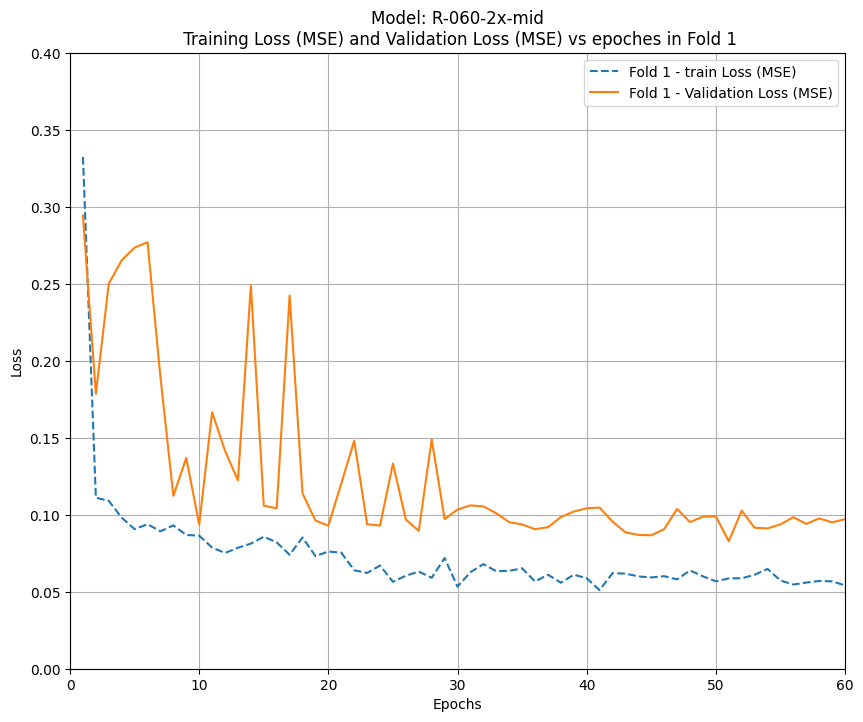

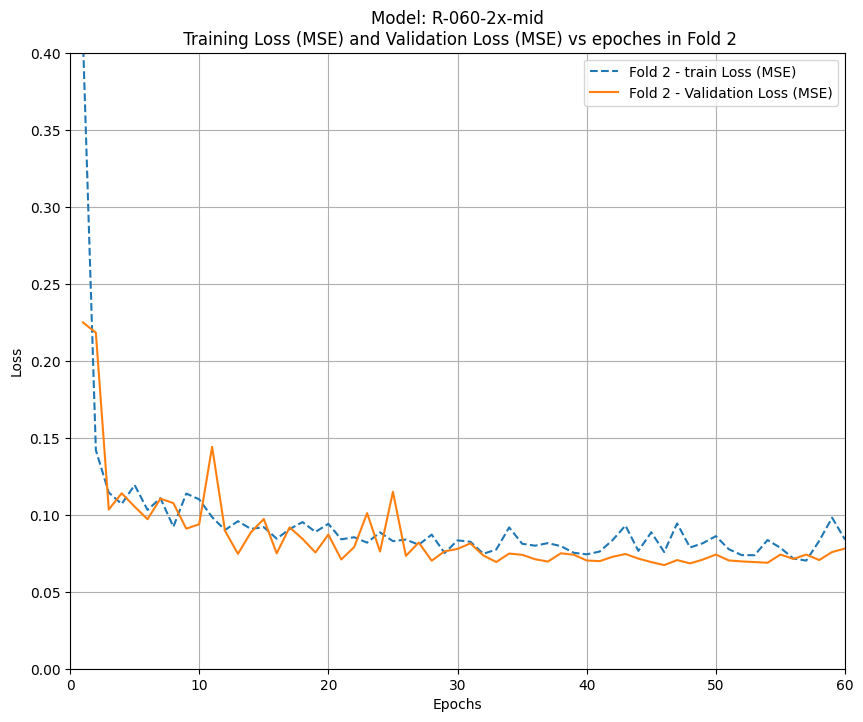

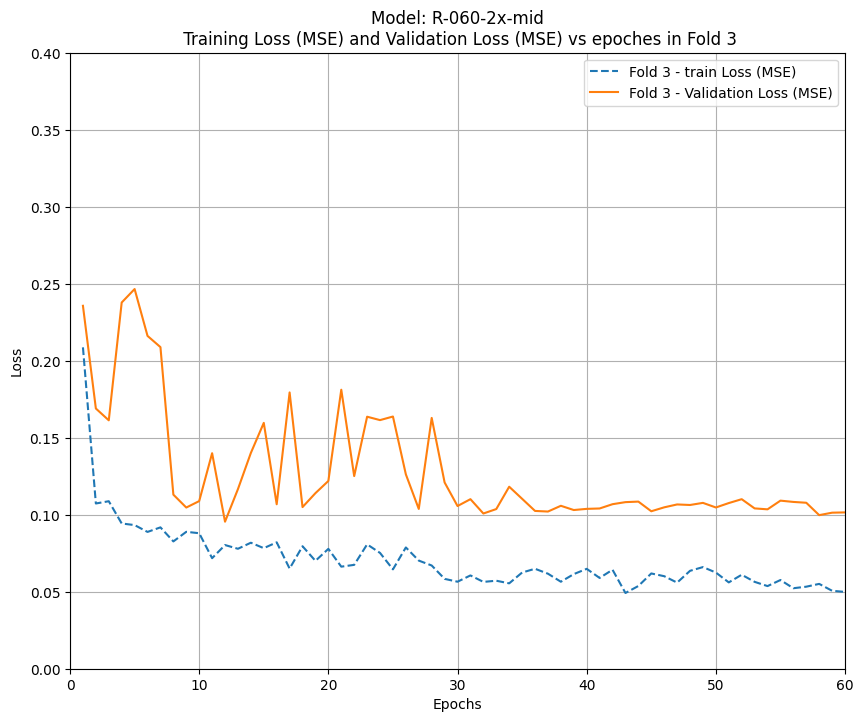

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_1008x672_3/results_with_mse.csv


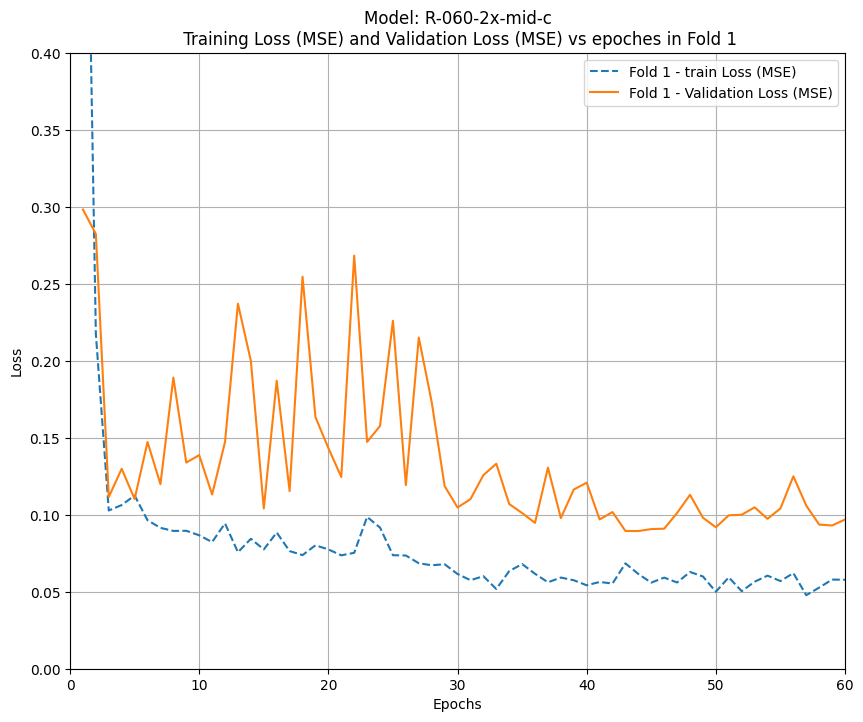

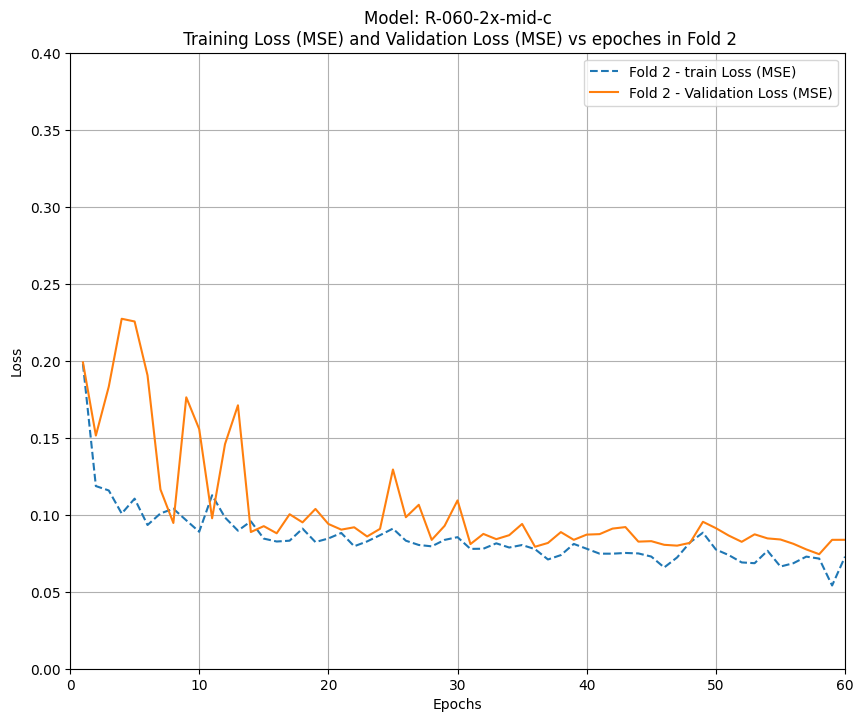

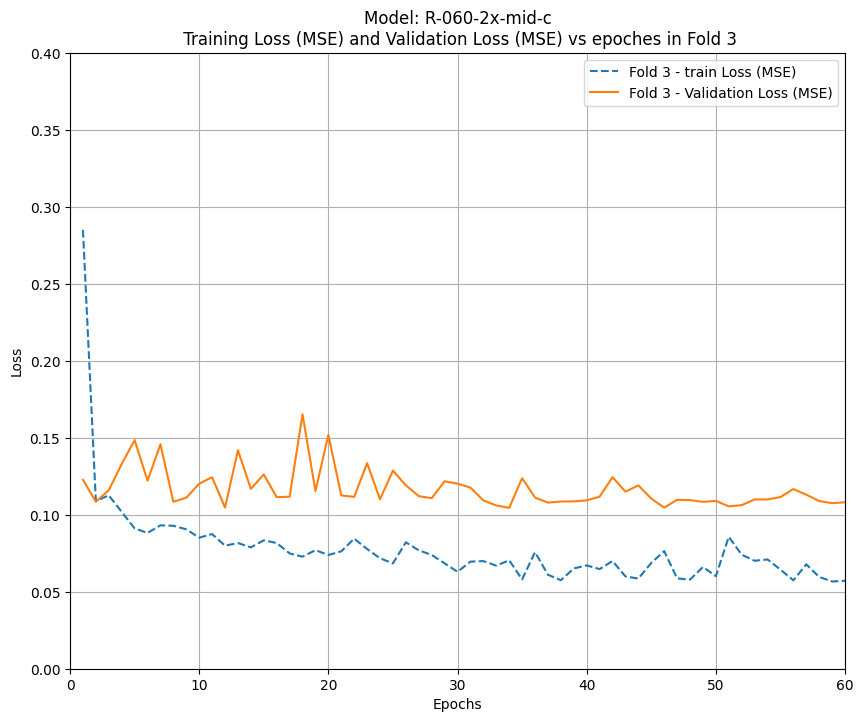

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_4_3/results_with_mse.csv


<Figure size 1000x800 with 0 Axes>

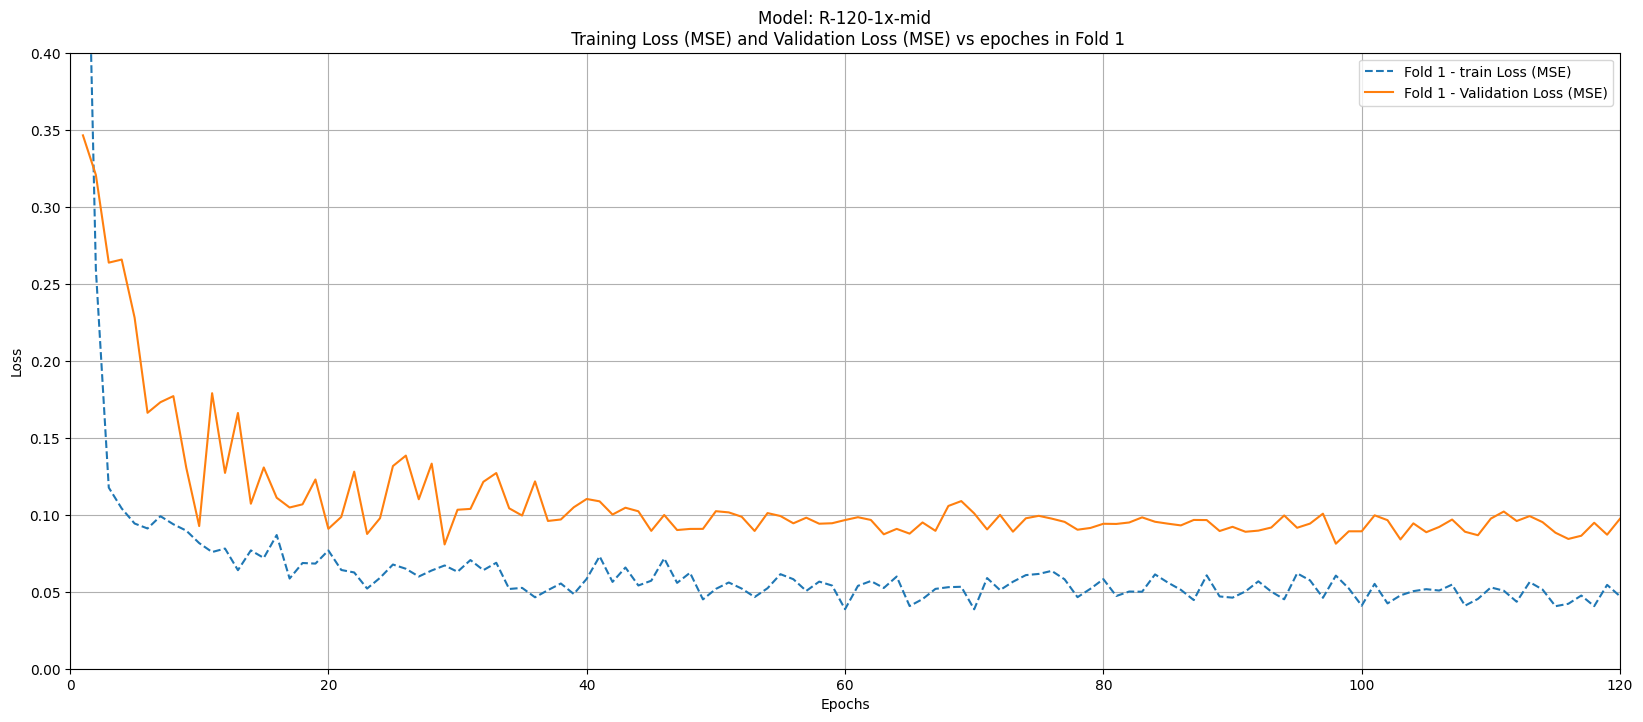

<Figure size 1000x800 with 0 Axes>

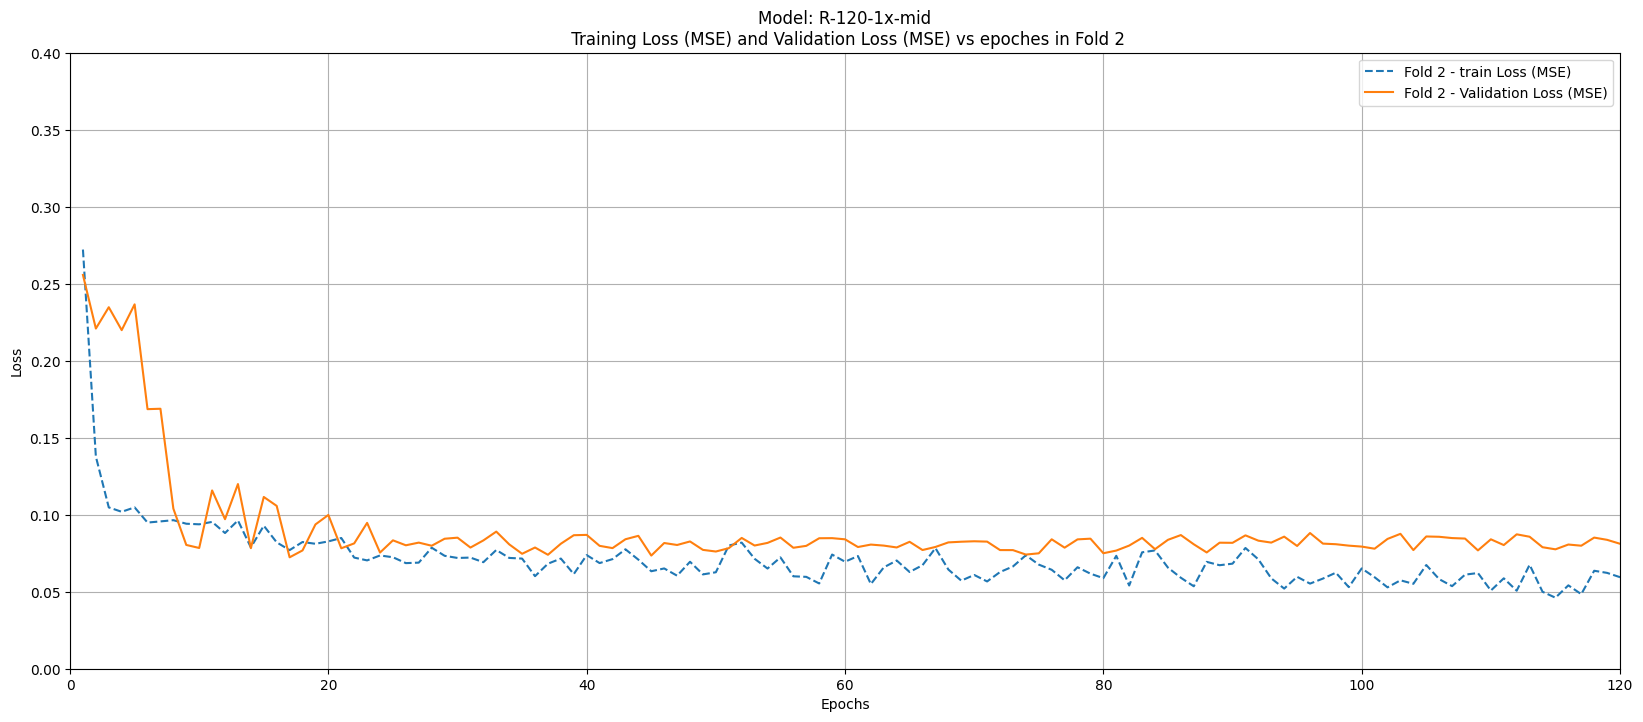

<Figure size 1000x800 with 0 Axes>

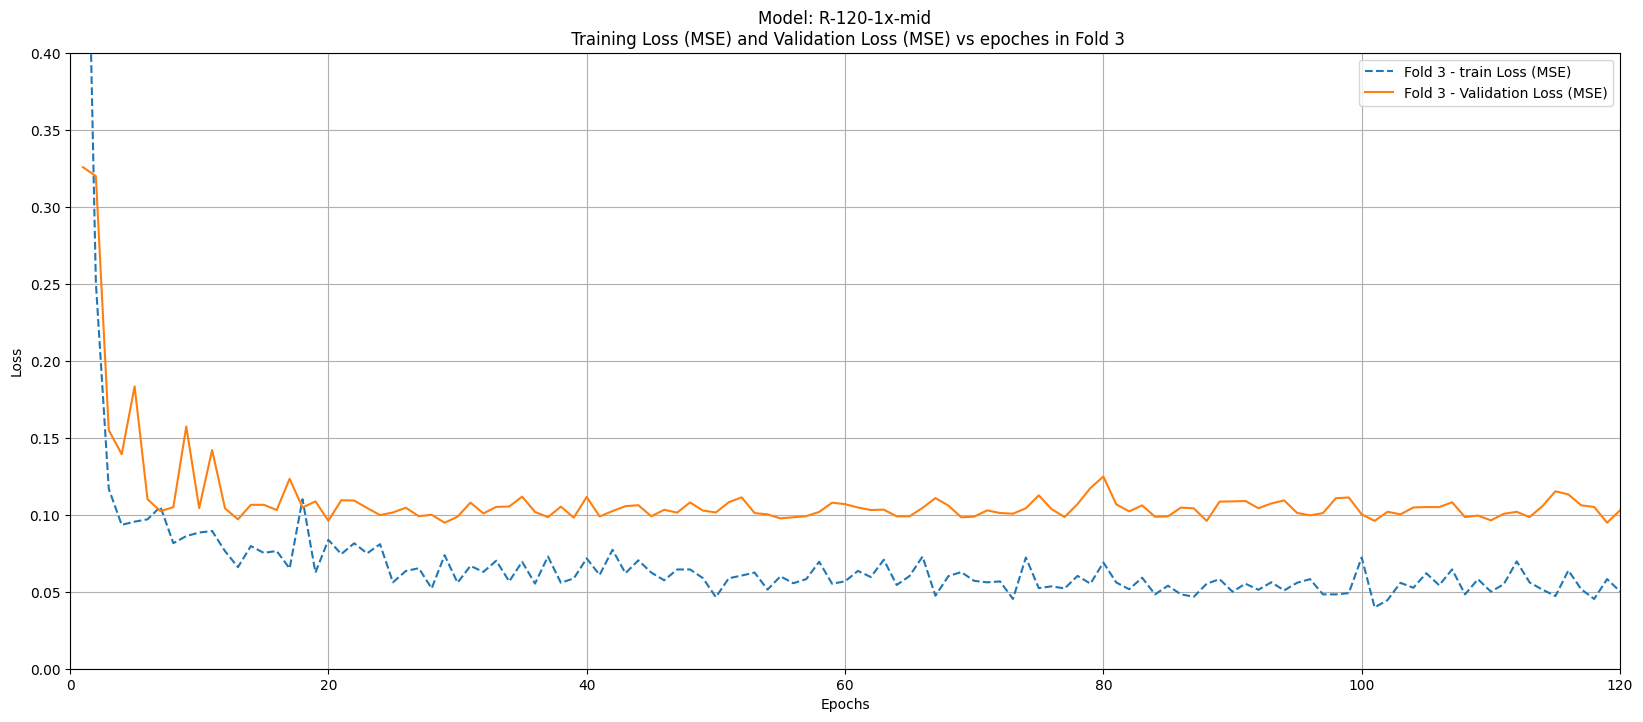

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_4_3/results_with_mse.csv


<Figure size 1000x800 with 0 Axes>

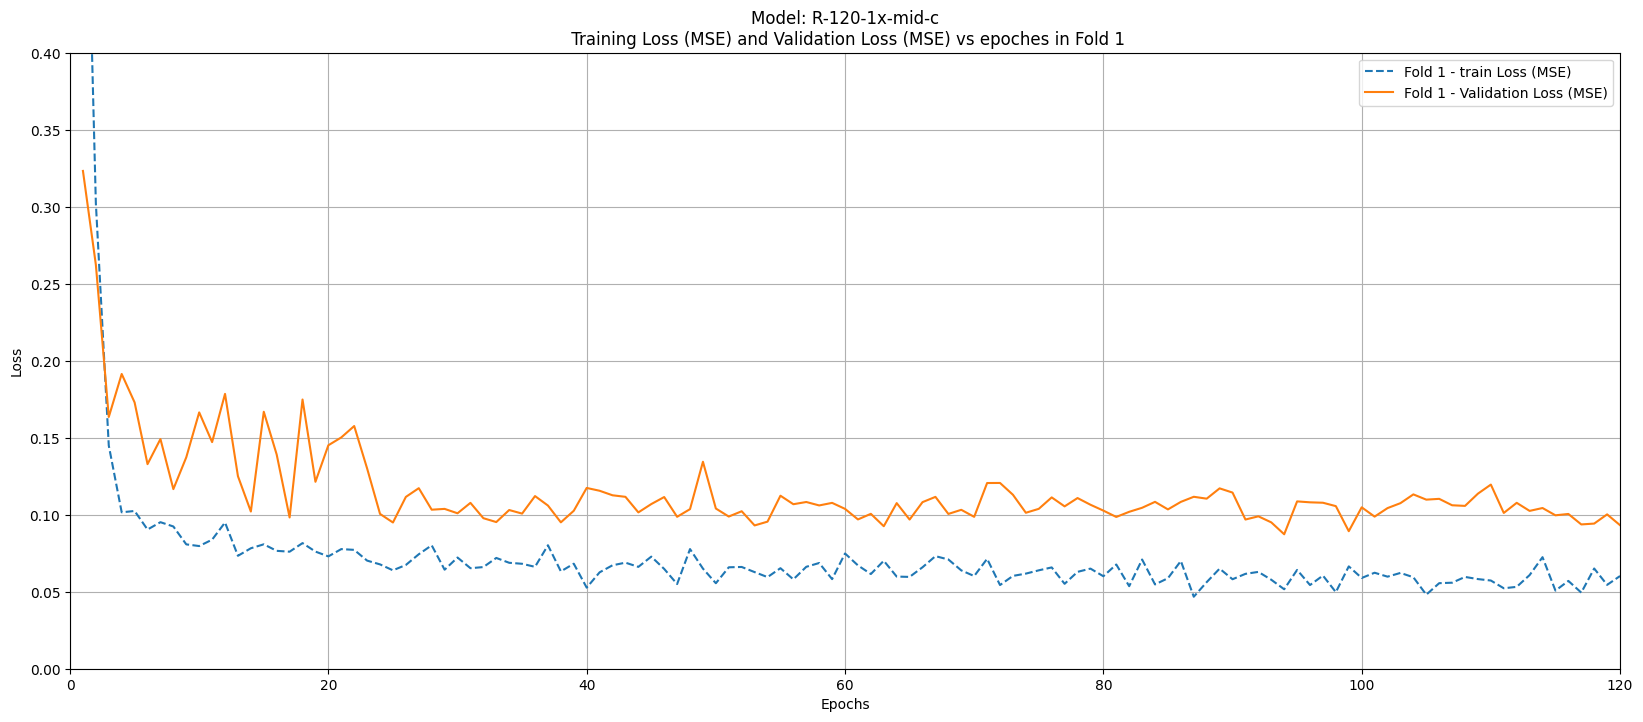

<Figure size 1000x800 with 0 Axes>

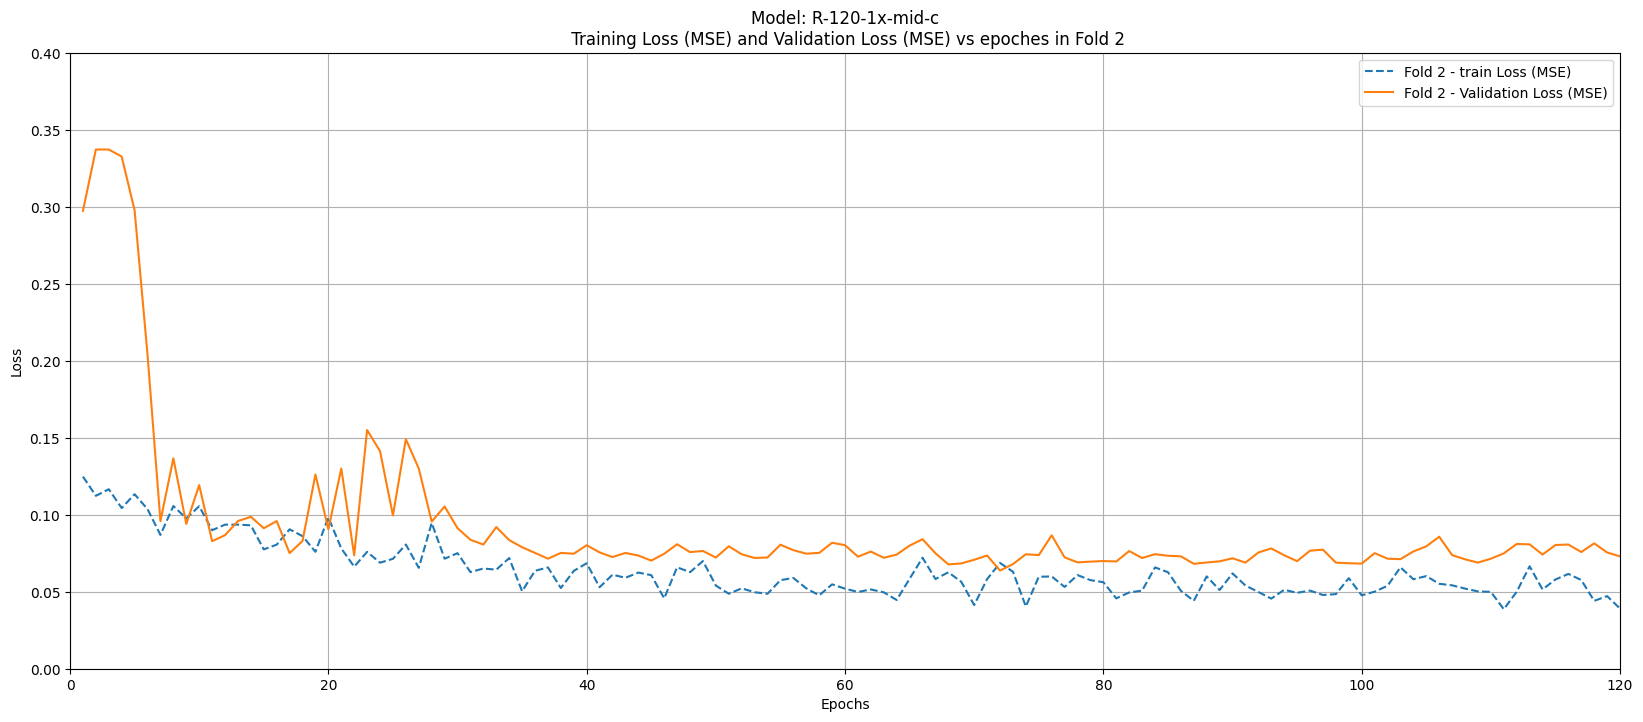

<Figure size 1000x800 with 0 Axes>

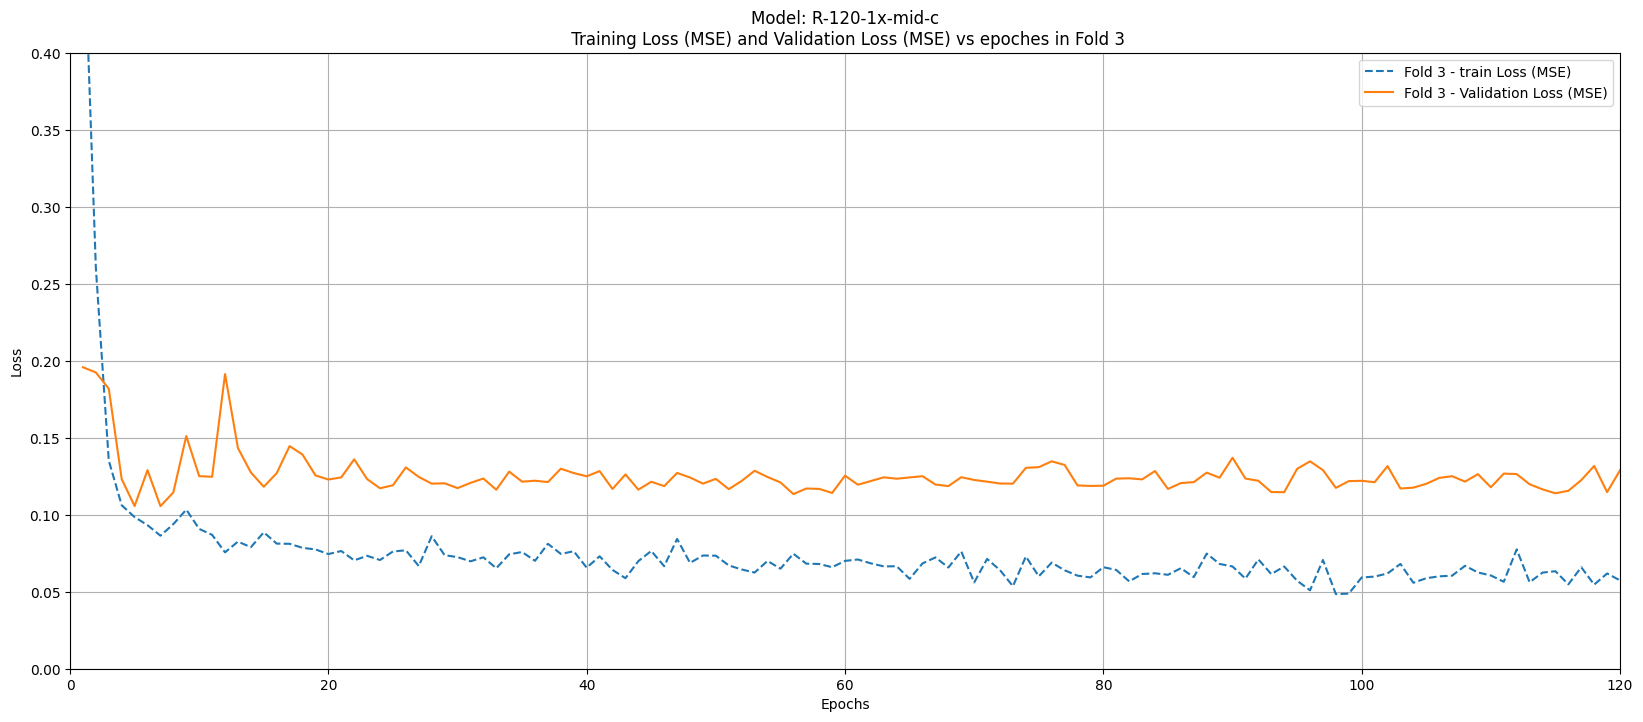

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_5_4/results_with_mse.csv


<Figure size 1000x800 with 0 Axes>

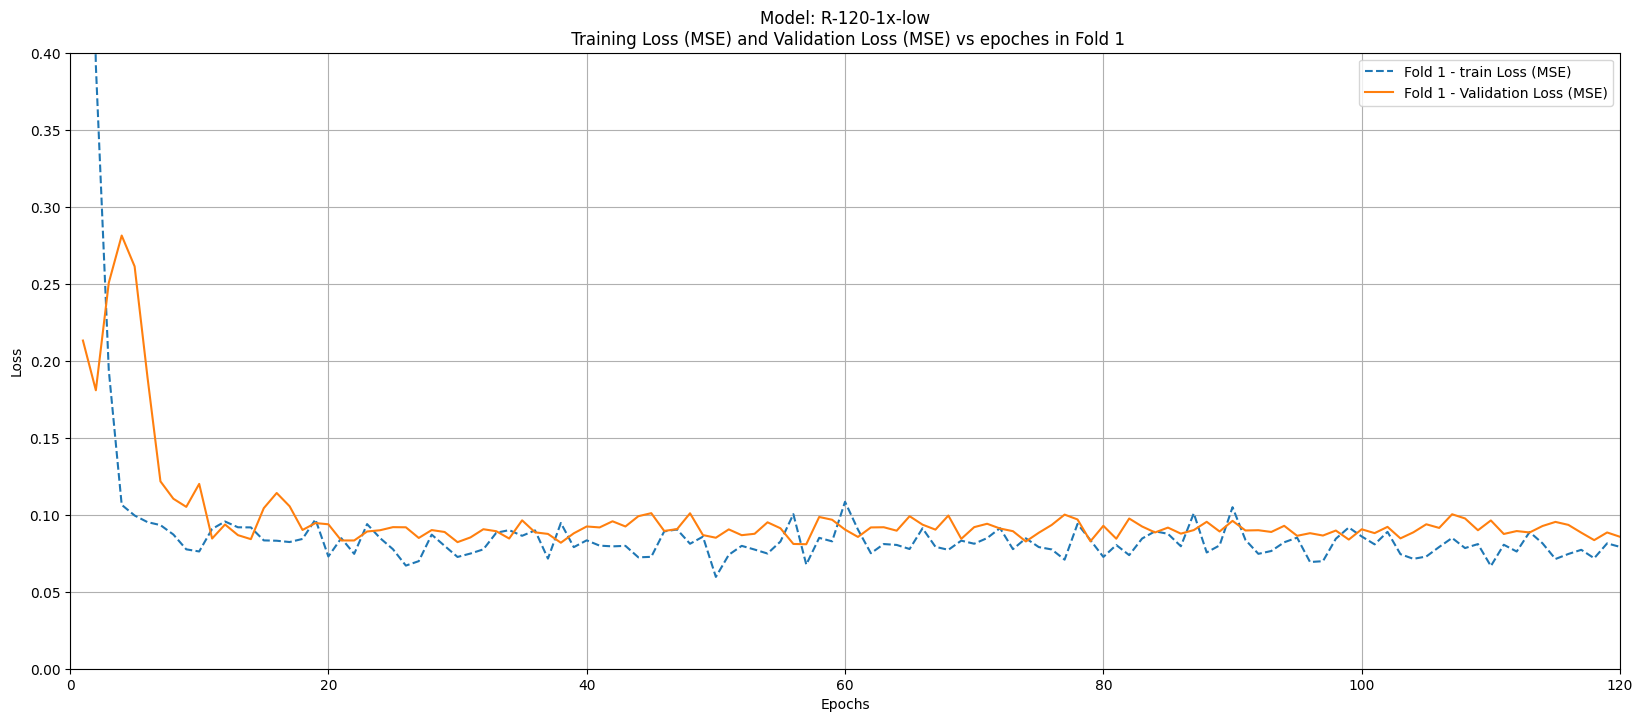

<Figure size 1000x800 with 0 Axes>

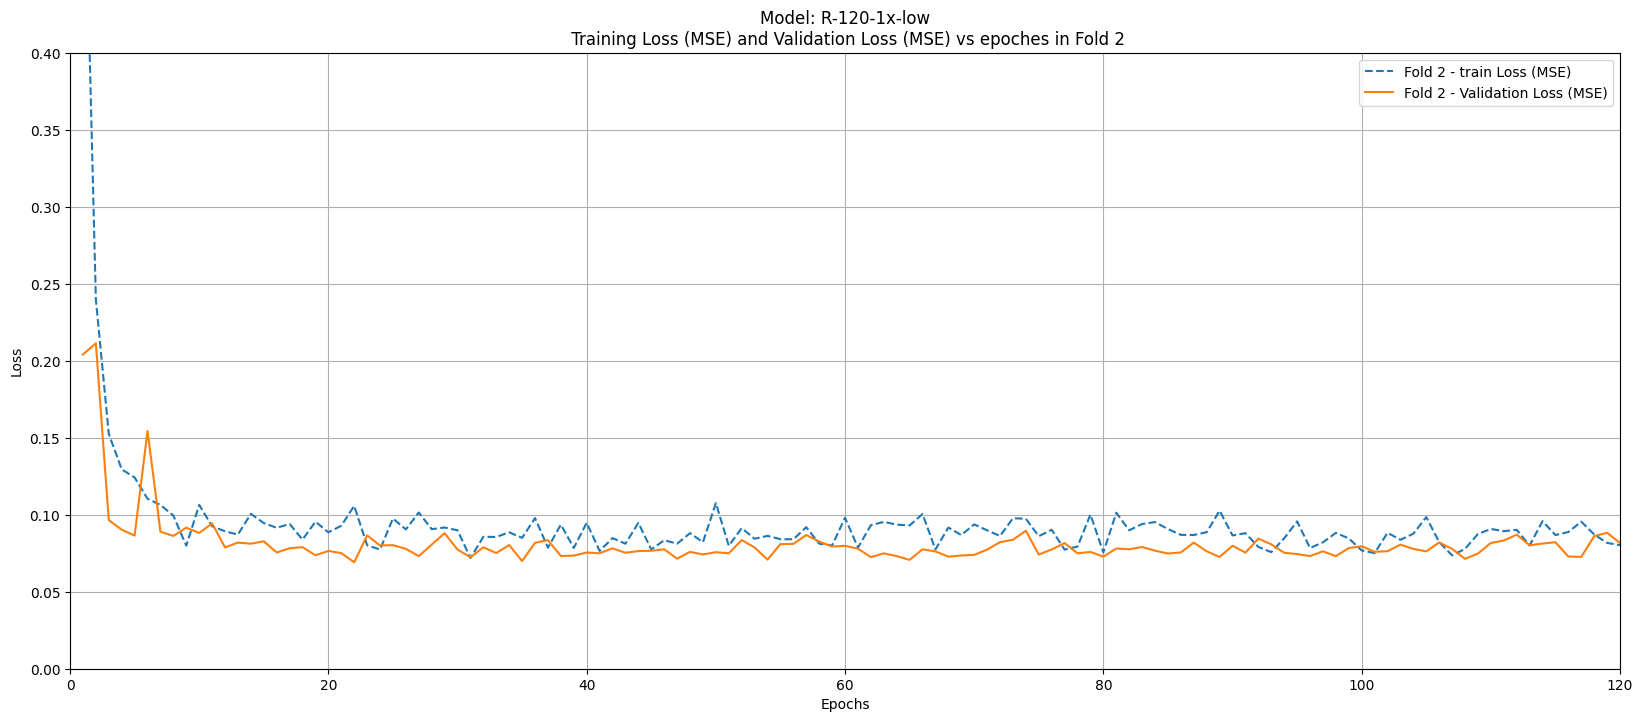

<Figure size 1000x800 with 0 Axes>

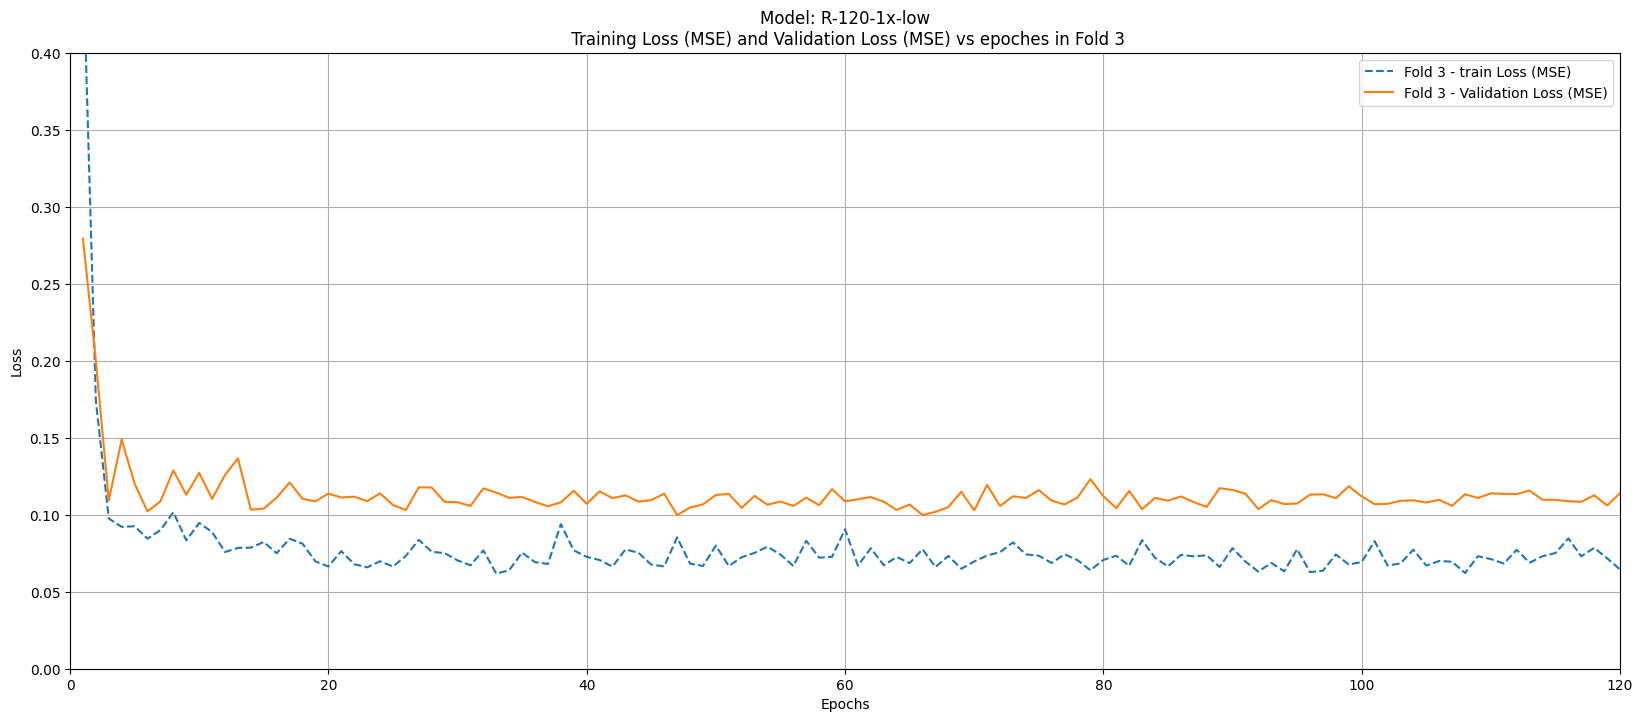

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_5_3/results_with_mse.csv


<Figure size 1000x800 with 0 Axes>

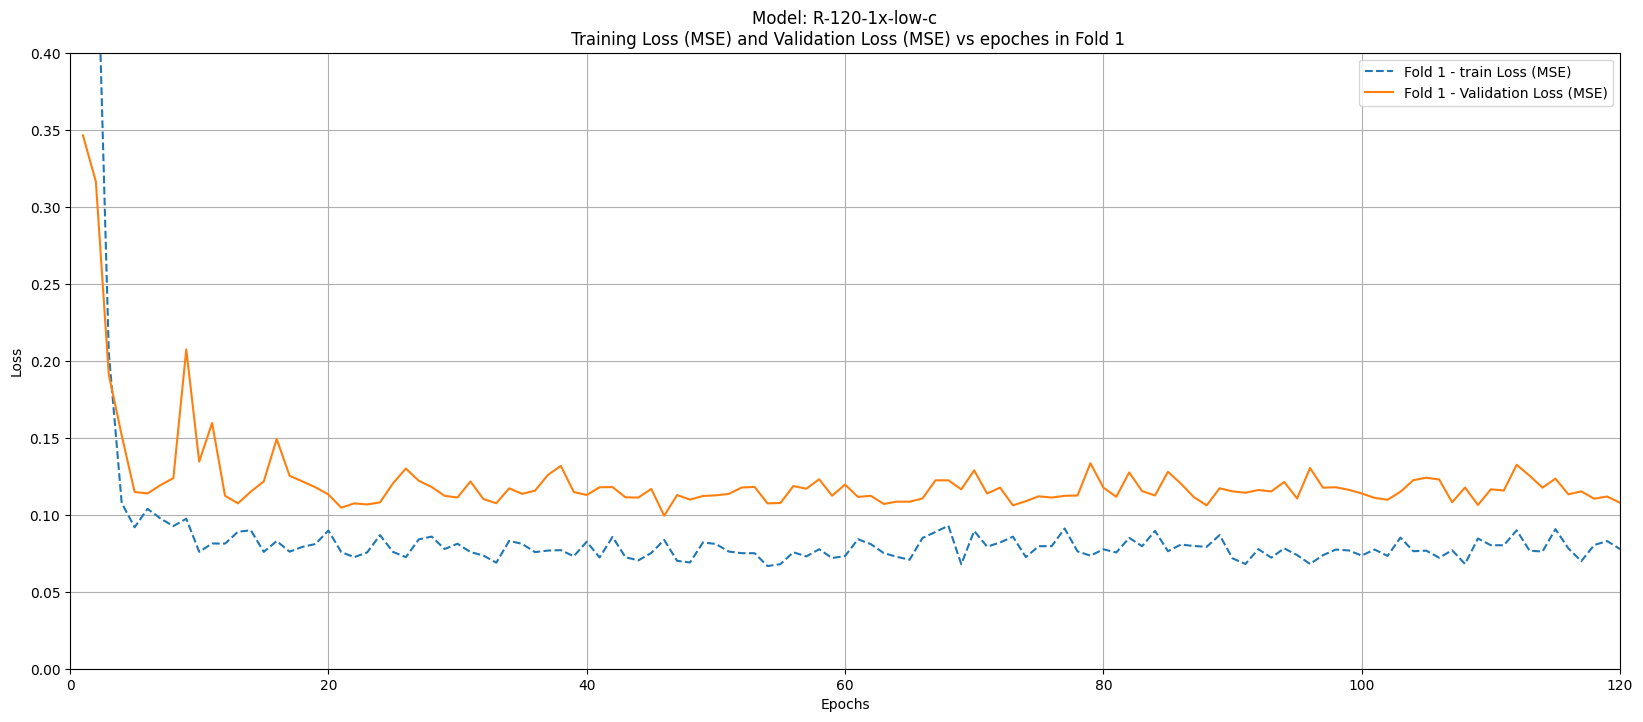

<Figure size 1000x800 with 0 Axes>

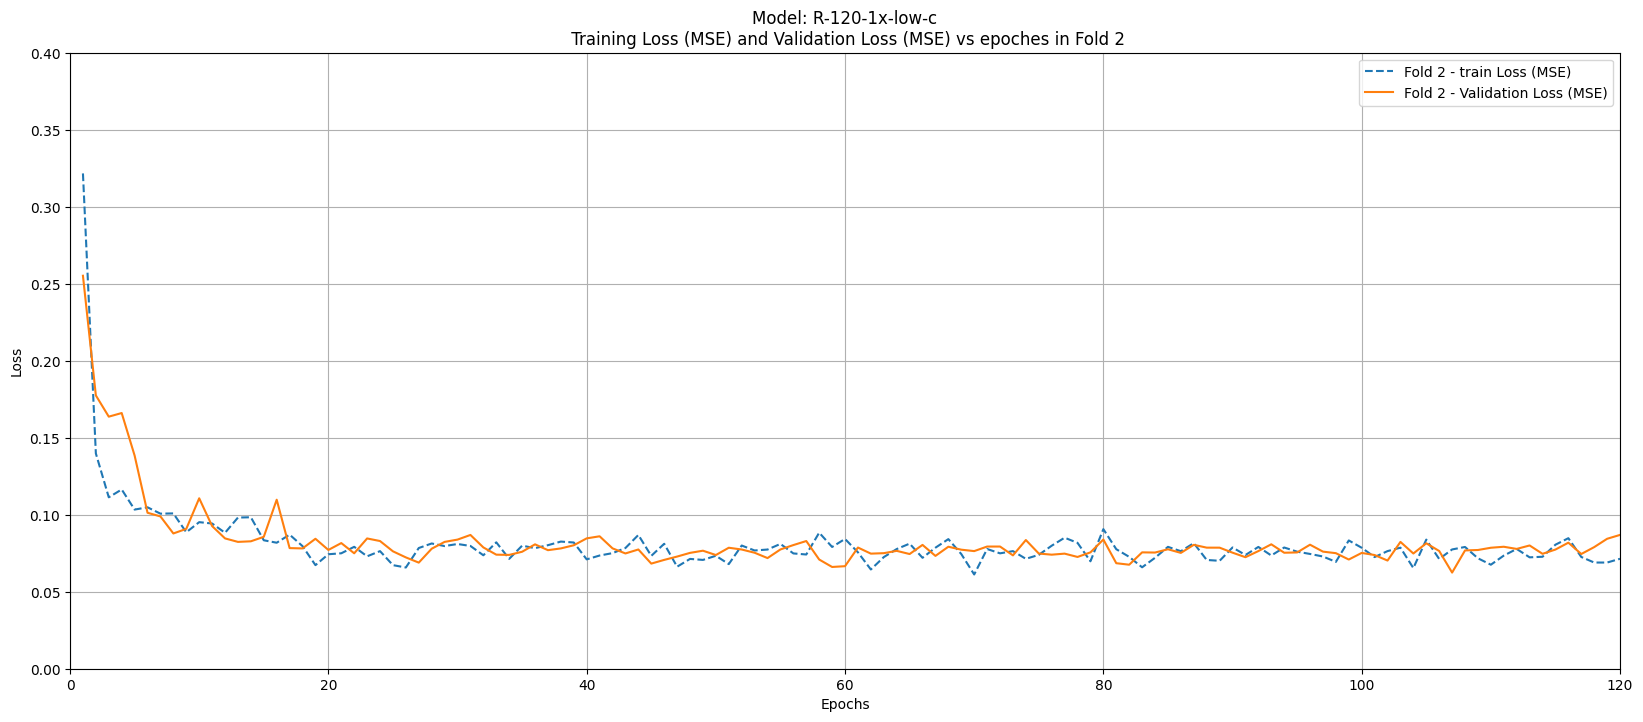

<Figure size 1000x800 with 0 Axes>

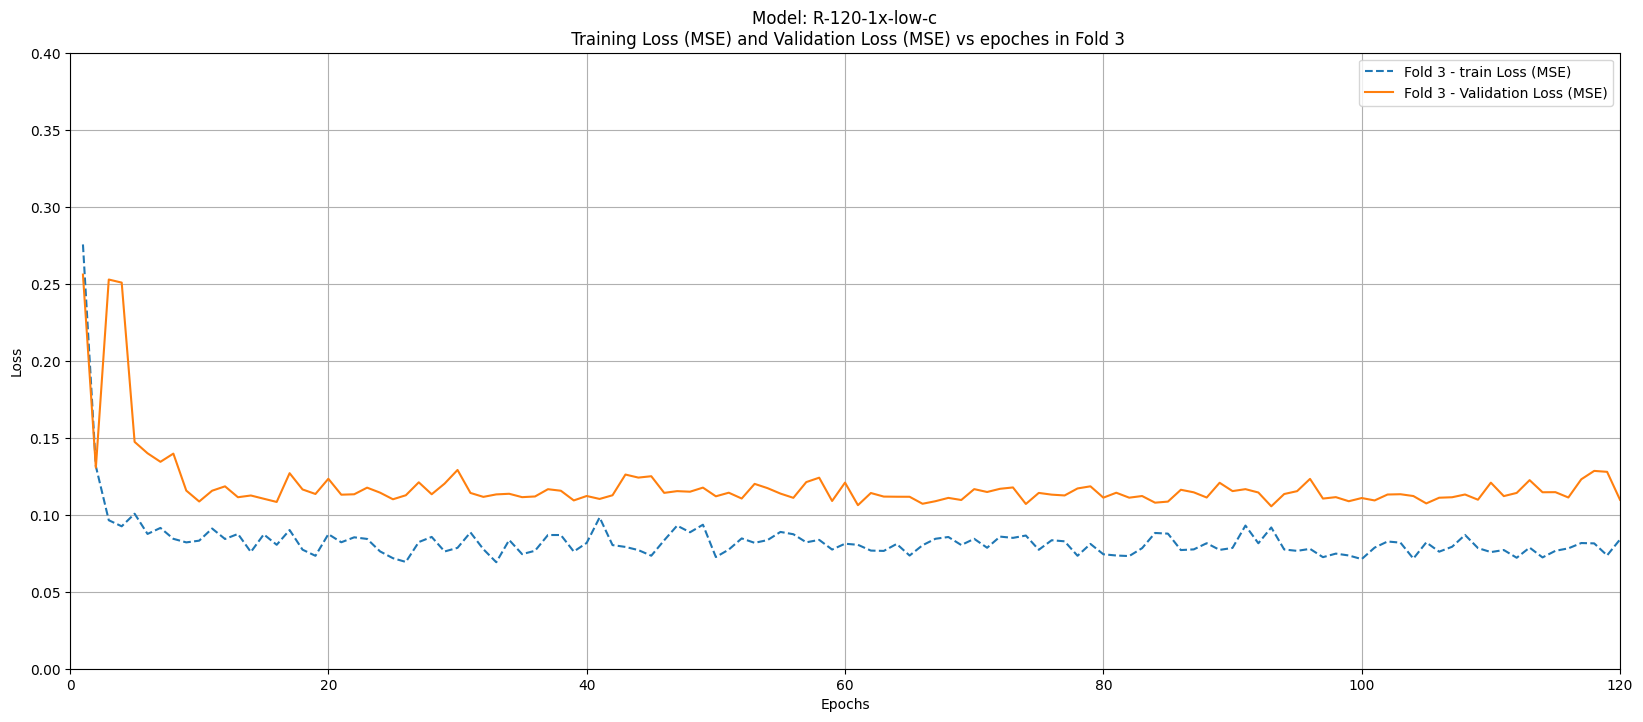

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_data_aug_3/results_with_mse.csv


<Figure size 1000x800 with 0 Axes>

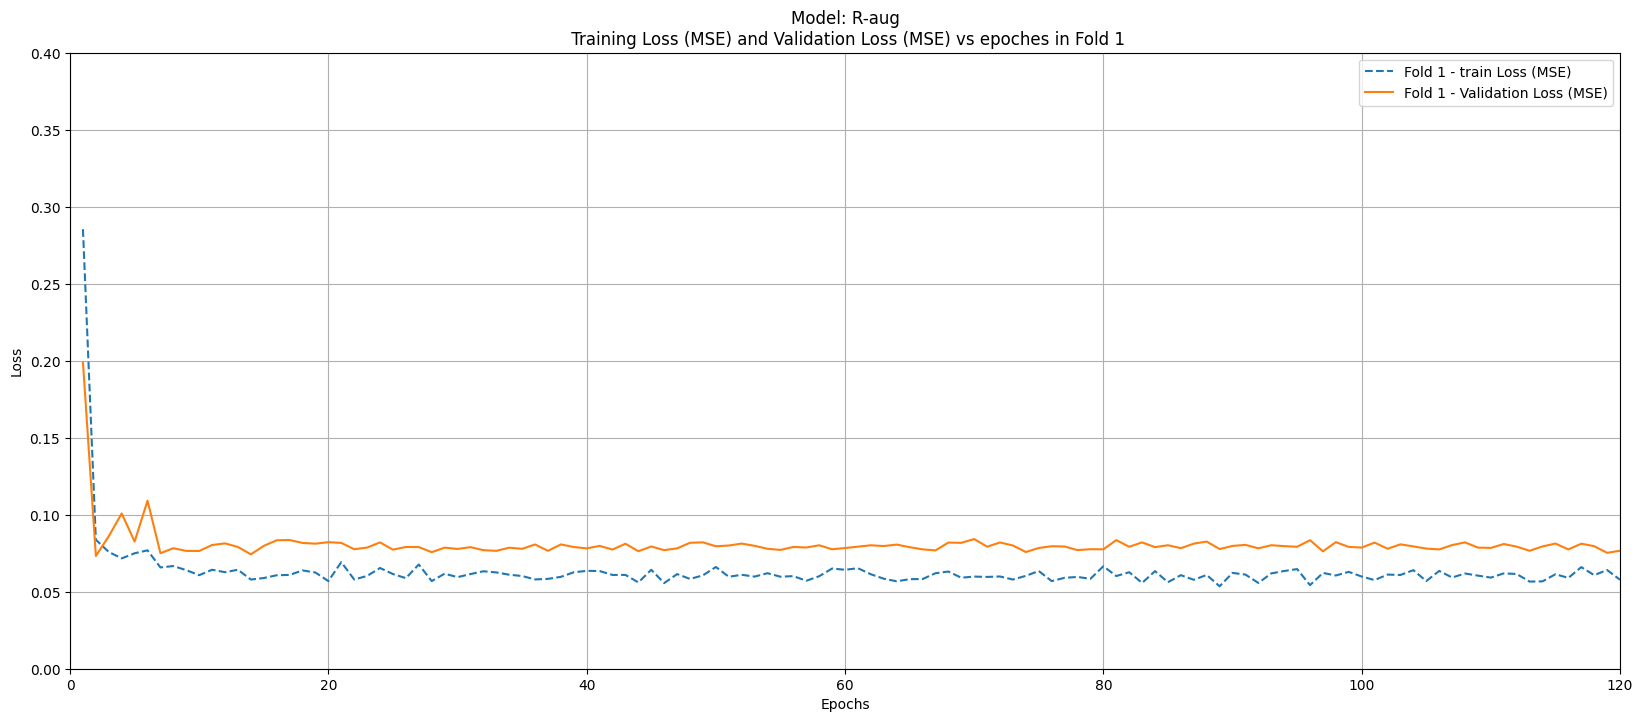

<Figure size 1000x800 with 0 Axes>

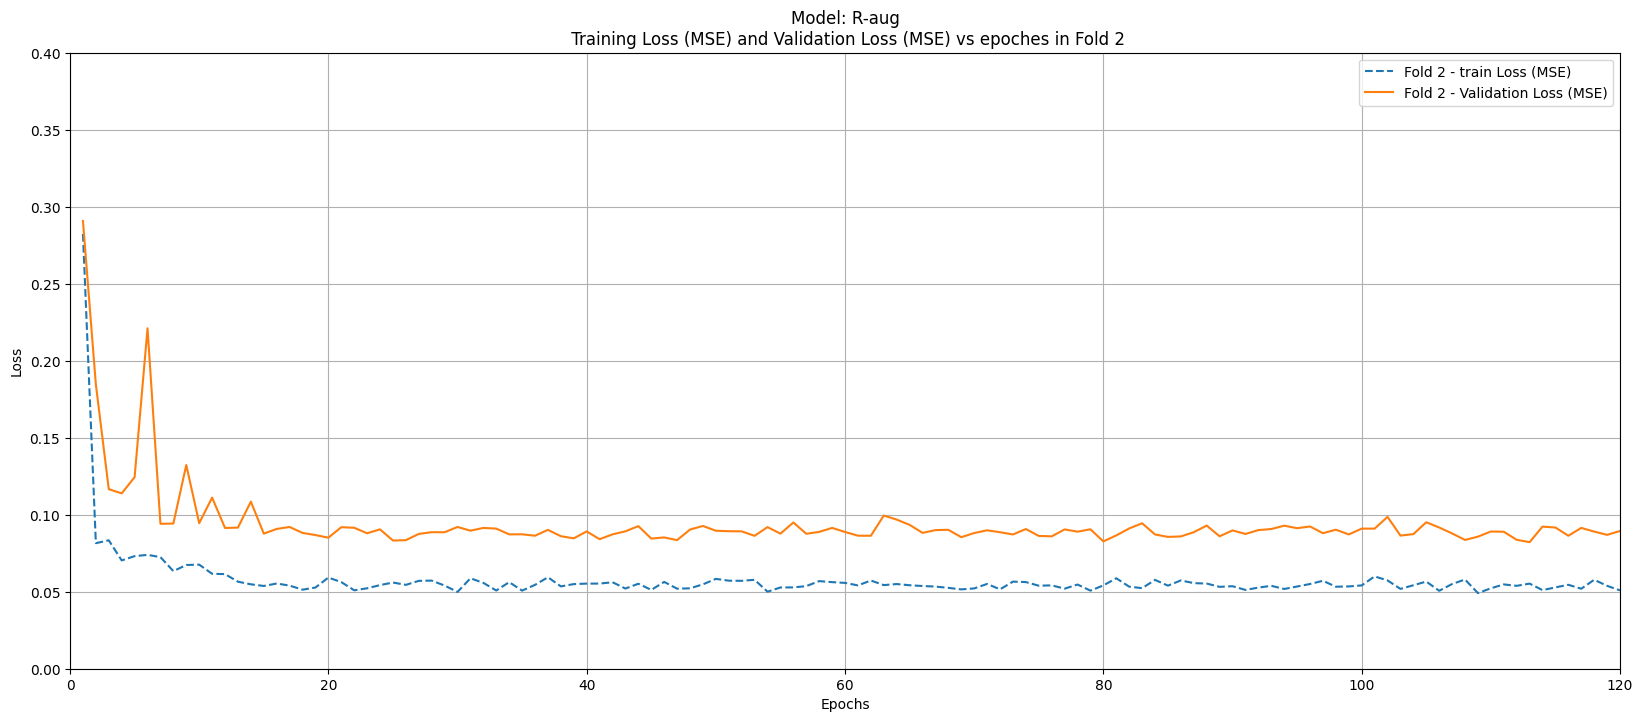

<Figure size 1000x800 with 0 Axes>

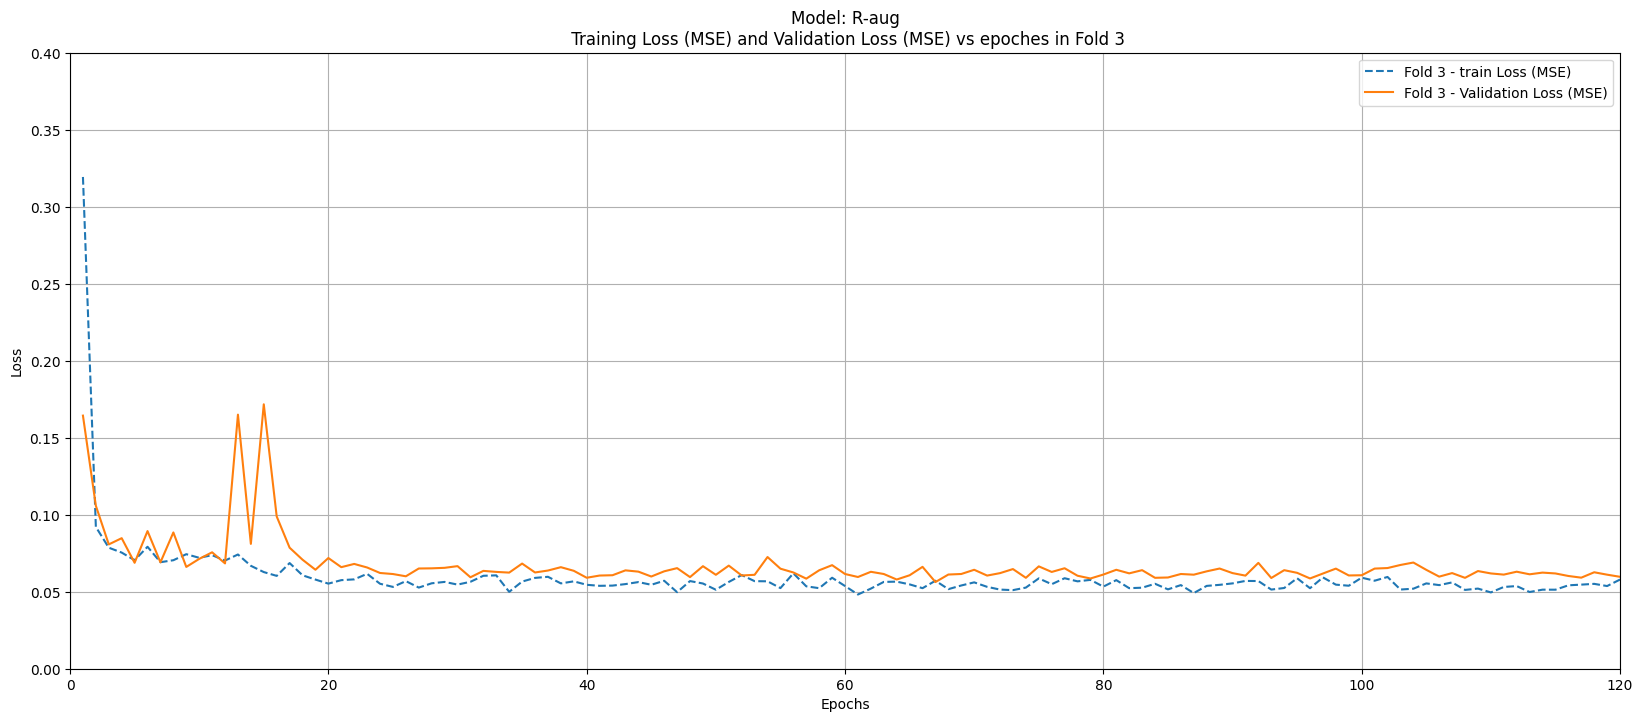

trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_data_aug_3/results_with_mse.csv


<Figure size 1000x800 with 0 Axes>

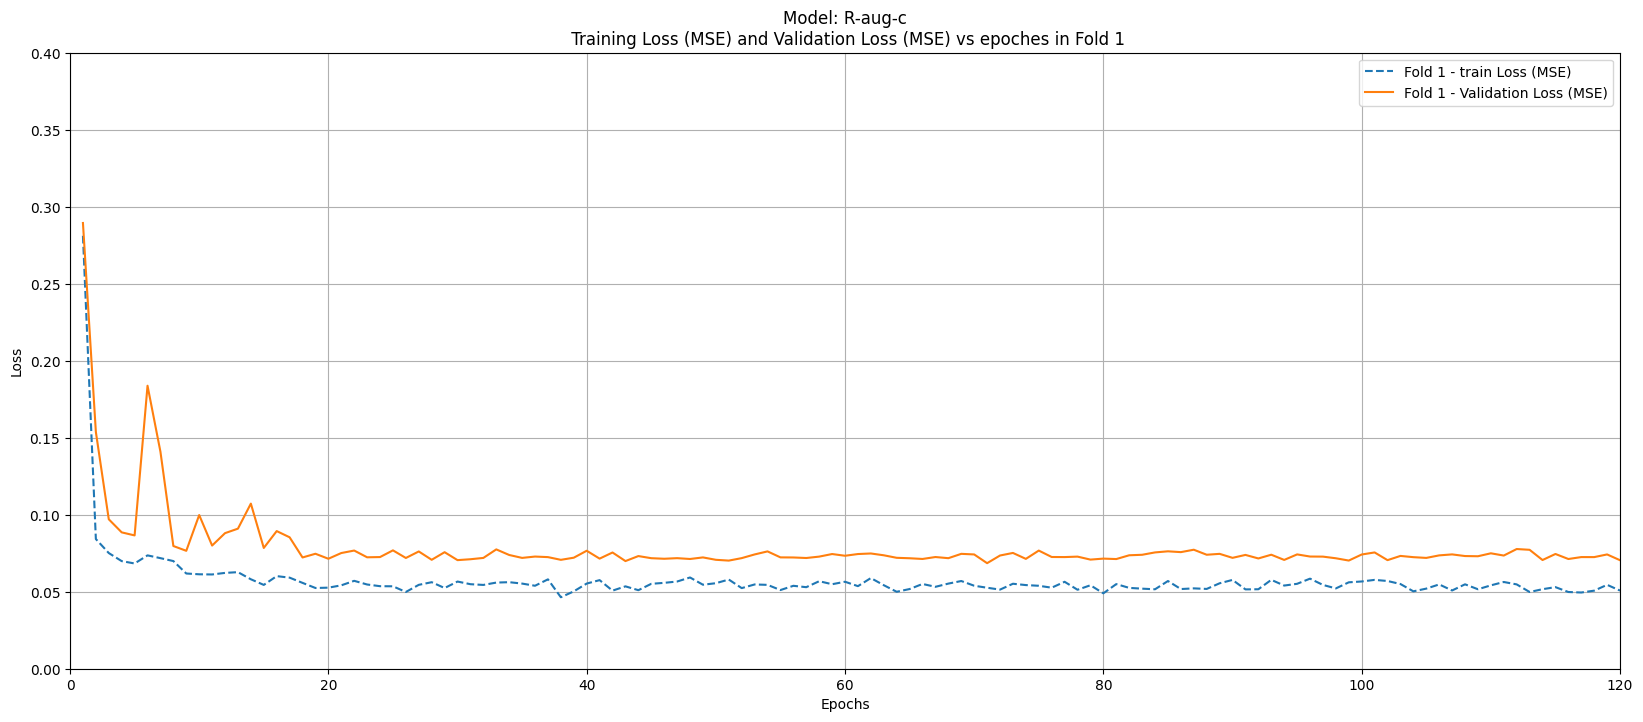

<Figure size 1000x800 with 0 Axes>

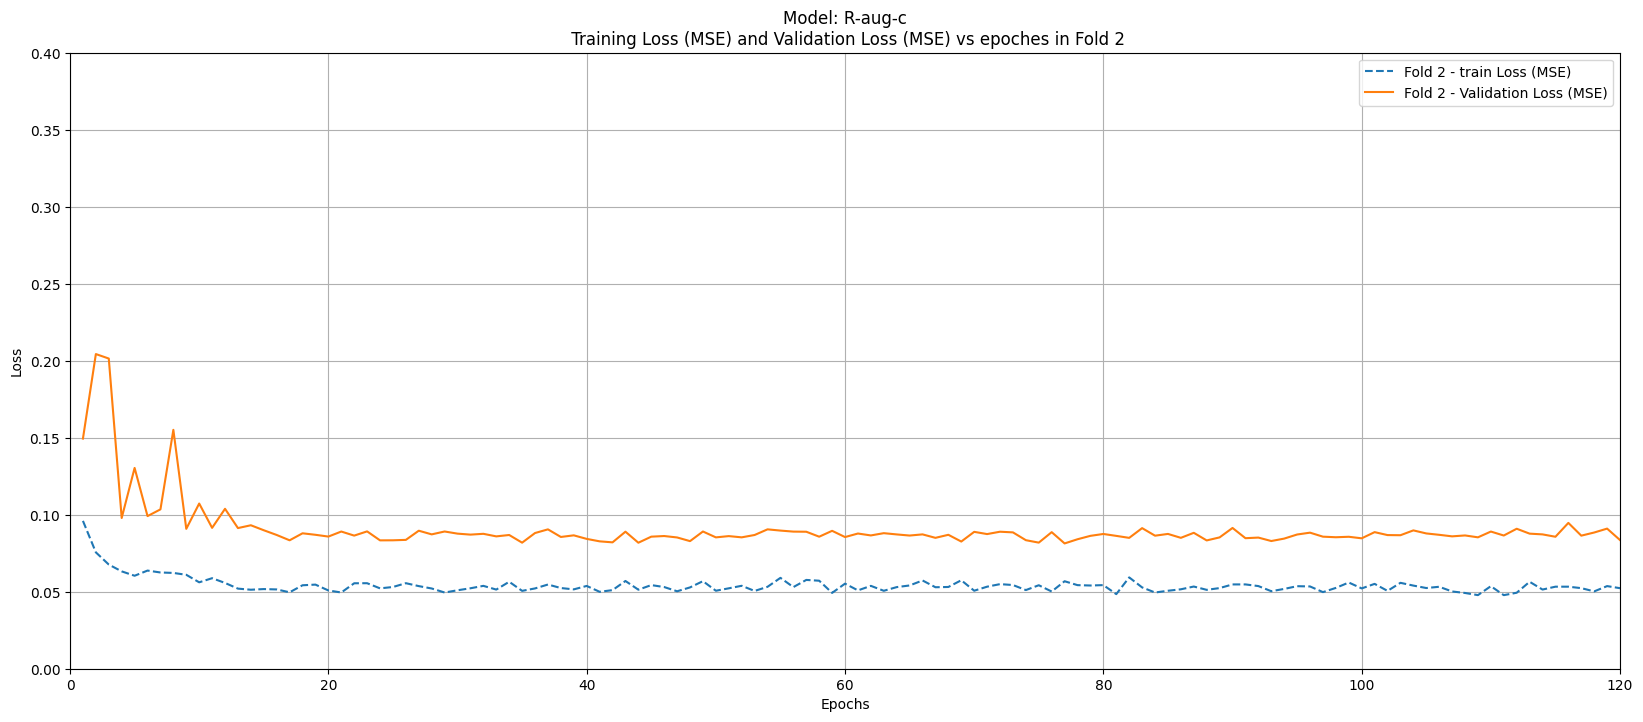

<Figure size 1000x800 with 0 Axes>

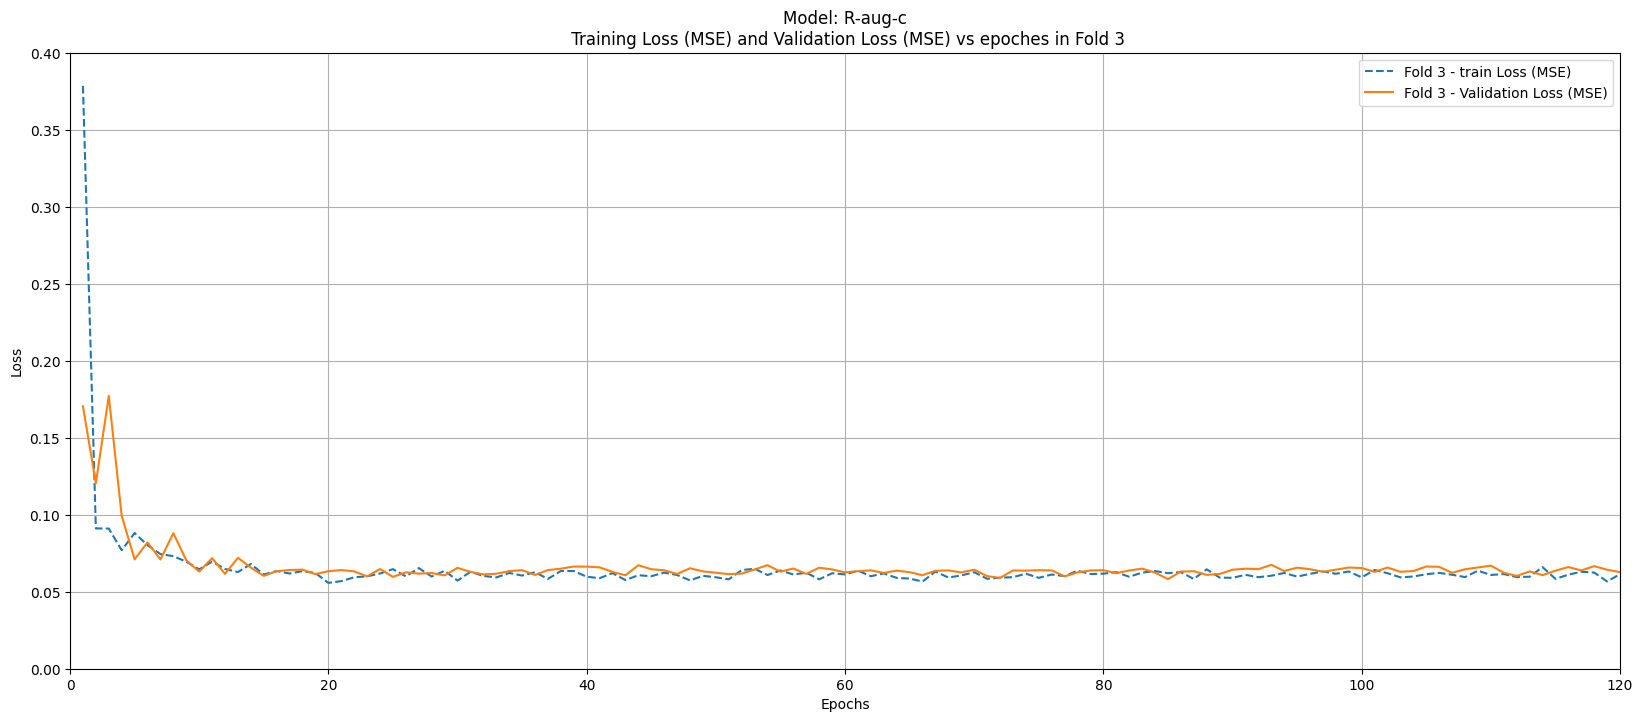

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

dic = {1: "R-060-1x-mid",
       2:"R-060-1x-mid-c",
       3:"R-060-2x-mid",
       4:"R-060-2x-mid-c",
       5:"R-120-1x-mid",
       6:"R-120-1x-mid-c",
       7:"R-120-1x-low",
       8:"R-120-1x-low-c",
       9:"R-aug",
       10:"R-aug-c"
}

def show_mse_statistics(model_data, i):
  print(model_data)
  df = pd.read_csv(model_data)

  # Define folds & column names
  folds = ["Fold 1", "Fold 2", "Fold 3"]
  #folds = ["Fold 1", "Fold 2", "Fold 3", "Fold 4"]
  train_cols = [f"{fold} - Train Loss" for fold in folds]
  val_cols = [f"{fold} - Val Loss (MSE)" for fold in folds]

  for fold, train_col, val_col in zip(folds, train_cols, val_cols):
    plt.figure(figsize=(10,8)) #width by height
    num_epochs = len(df)
    if num_epochs == 120:
      plt.figure(figsize=(20,8))


    #set epoches limit
    plt.ylim(0, 0.4)
    plt.xlim(0, len(df))




    plt.plot(df['Epoch'], df[train_col], linestyle="--", label=f"{fold} - train Loss (MSE)")
    plt.plot(df['Epoch'], df[val_col], label=f"{fold} - Validation Loss (MSE)")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Model: {dic[i]}\n Training Loss (MSE) and Validation Loss (MSE) vs epoches in {fold}")
    #plt.suptitle(f"Model: {dic[1]}")
    plt.legend()
    plt.grid(True)
    plt.show()

show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_896x672_3/results_with_mse.csv', 3)
show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_1008x672_3/results_with_mse.csv', 4)
show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_4_3/results_with_mse.csv', 5)
show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_4_3/results_with_mse.csv', 6)
show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_5_4/results_with_mse.csv', 7)
show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_5_3/results_with_mse.csv', 8)
show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_data_aug_3/results_with_mse.csv', 9)
show_mse_statistics('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_data_aug_3/results_with_mse.csv', 10)

## Test ANN with custom labels

In [ ]:
model_str = 'resnext101_32x8d'
batch_size = 1
labels_set = [0,1]
combine_images = False
image_type = 'plastic'



# Initialize the model
model = get_model(model_str)
sd = torch.load('trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_3_3/fold_1_best_model.pt')
save_dir = 'trained_models/resnext101_32x8d_3_fold_adam_single_plastic_cropped_3_3/testing_stats.xlsx'
model.load_state_dict(sd)
model.cuda().eval()  # Move model to GPU and set it to evaluation mode

#def labeled_test(model, batch_size=1, labels_set=[], combine_images=True, image_type='both', save_path="test_results.xlsx",  want_normalise=False):
#resnext101_32x8d_3_fold_adam_single_plastic_2
#resnext101_32x8d_3_fold_adam_single_plastic_cropped_2

print('\nTesting model for labels {}'.format(labels_set))
labeled_test(model = model, batch_size = batch_size, want_normalise= True, labels_set= labels_set, combine_images=combine_images, image_type=image_type, save_path=save_dir)


Testing model for labels [0, 1]
Total test items: 57
--Test item     0
Prediction Normalized: [[0.3074979 0.5899541]]
Actual Normalized:     [[0.         0.44620255]]

--Test item     1
Prediction Normalized: [[0.18856491 0.7130674 ]]
Actual Normalized:     [[0.         0.47231013]]

--Test item     2
Prediction Normalized: [[-0.5212546   0.71247846]]
Actual Normalized:     [[0.  0.5]]

--Test item     3
Prediction Normalized: [[0.5839188  0.80838597]]
Actual Normalized:     [[0.        0.5561709]]

--Test item     4
Prediction Normalized: [[-2.4221537  0.6549279]]
Actual Normalized:     [[0.        0.5276899]]

--Test item     5
Prediction Normalized: [[0.37768355 0.60807407]]
Actual Normalized:     [[0.       0.613924]]

--Test item     6
Prediction Normalized: [[0.01242982 0.8053912 ]]
Actual Normalized:     [[0.        0.8971519]]

--Test item     7
Prediction Normalized: [[-0.05644359  0.78380173]]
Actual Normalized:     [[0.         0.64398736]]

--Test item     8
Prediction Nor

0.26526016402139996

# End of current code>

## Clean

In [ ]:
import torch

del model

torch.cuda.empty_cache()
print(torch.cuda.is_available())